# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Наша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. 

### Откроем файл с данными и изучим общую информацию. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import warnings

In [2]:
pd.set_option('display.max_columns', 100) #настраиваем максимальное количество столбцов для отображения 
warnings.filterwarnings('ignore') #убираем сообщения о предупреждениях

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


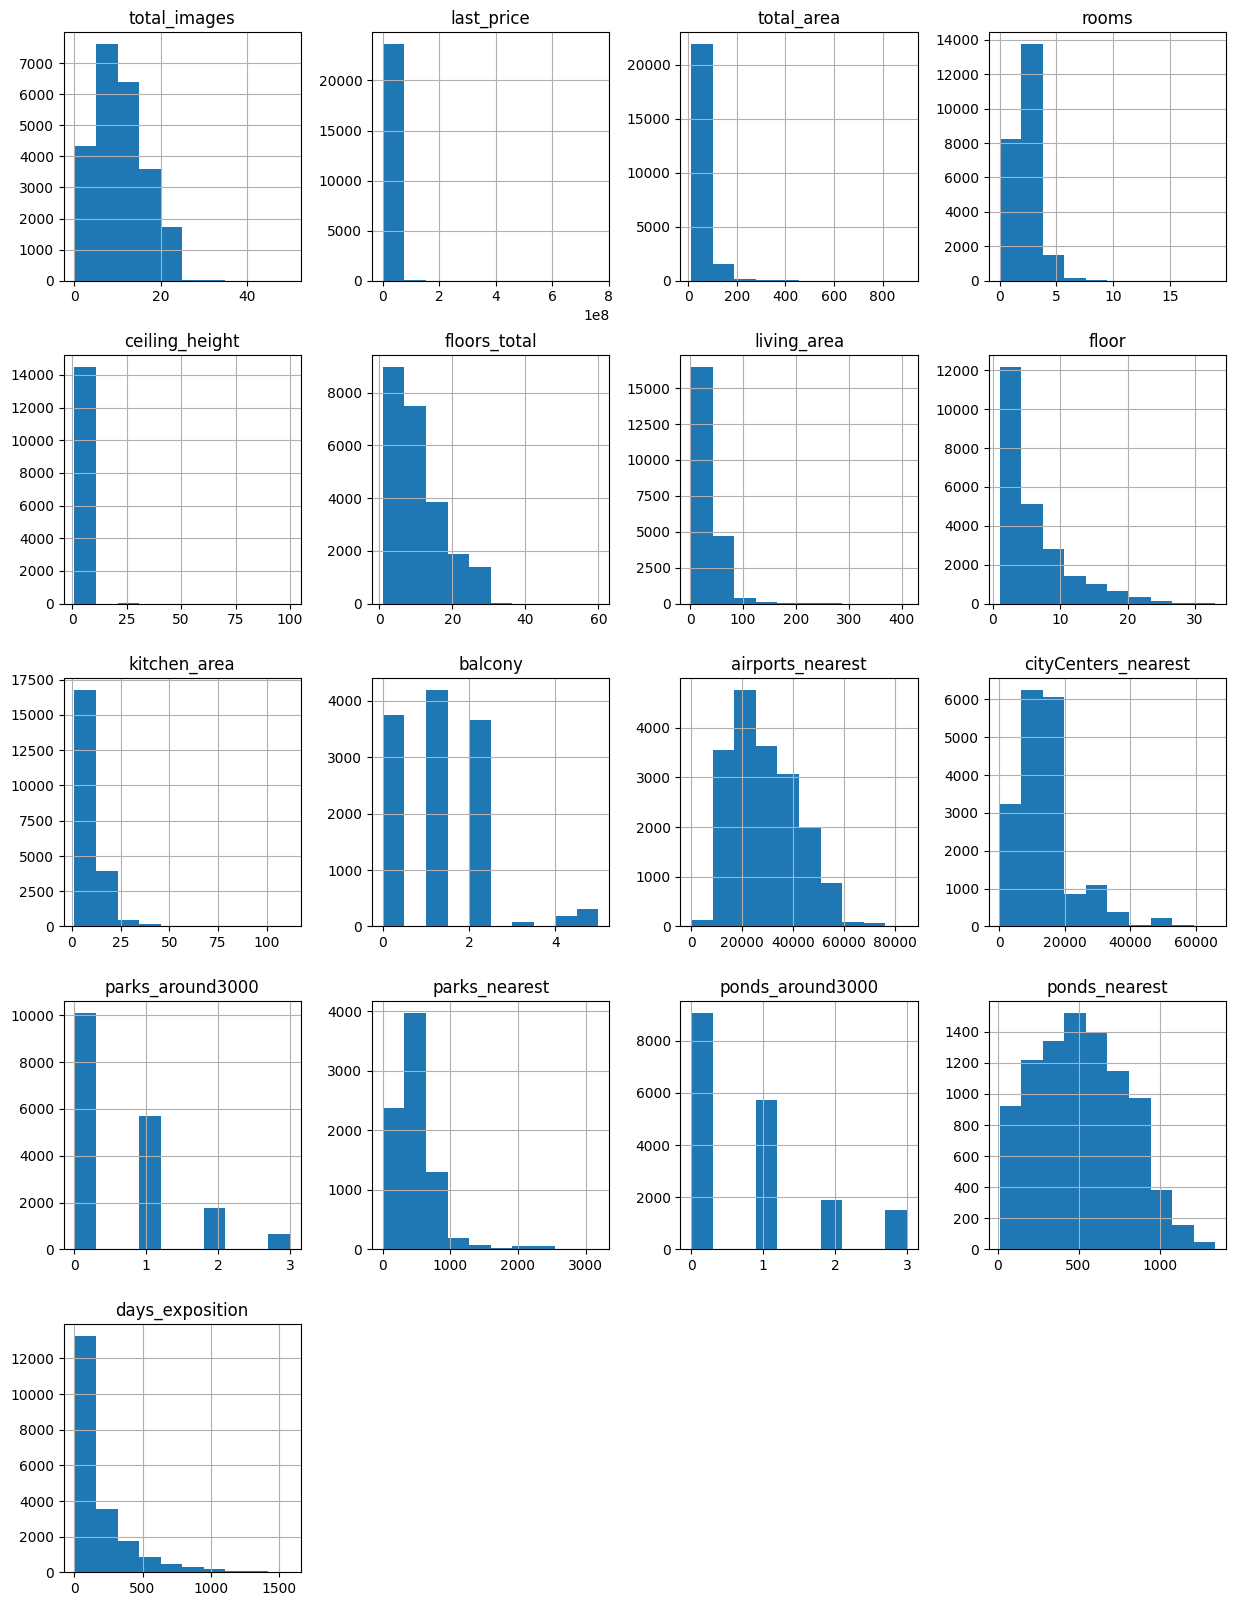

In [3]:
data = pd.read_csv(r'real_estate_data.csv', delimiter='\t')
display(data.head())
data.hist(figsize=(15, 20));

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

В нашей базе данных 22 столбца:

**airports_nearest** — расстояние до ближайшего аэропорта в метрах (м) 
<br>
**balcony** — число балконов
<br>
**ceiling_height** — высота потолков (м)
<br>
**cityCenters_nearest** — расстояние до центра города (м)
<br>
**days_exposition** — сколько дней было размещено объявление (от публикации до снятия)
<br>
**first_day_exposition** — дата публикации
<br>
**floor** — этаж
<br>
**floors_total** — всего этажей в доме
<br>
**is_apartment** — апартаменты (булев тип)
<br>
**kitchen_area** — площадь кухни в квадратных метрах (м²)
<br>
**last_price** — цена на момент снятия с публикации
<br>
**living_area** — жилая площадь в квадратных метрах (м²)
<br>
**locality_name** — название населённого пункта
<br>
**open_plan** — свободная планировка (булев тип)
<br>
**parks_around3000** — число парков в радиусе 3 км
<br>
**parks_nearest** — расстояние до ближайшего парка (м)
<br>
**ponds_around3000** — число водоёмов в радиусе 3 км
<br>
**ponds_nearest** — расстояние до ближайшего водоёма (м)
<br>
**rooms** — число комнат
<br>
**studio** — квартира-студия (булев тип)
<br>
**total_area** — общая площадь квартиры в квадратных метрах (м²)
<br>
**total_images** — число фотографий квартиры в объявлении

И данные по 23 699 квартирам.


### Перейдем к предобработке данных.

Проверим наличие явных дубликатов, чтобы сразу их удалить.

In [5]:
print('Количество явных дубликатов:', data.duplicated().sum())

Количество явных дубликатов: 0


Проверим наличие пропусков в данных.

In [6]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Проверим количество пропусков в процентом соотношении, чтобы оценить масштаб.

In [7]:
(data.isna().sum() / len(data)).round(4) * 100

total_images             0.00
last_price               0.00
total_area               0.00
first_day_exposition     0.00
rooms                    0.00
ceiling_height          38.80
floors_total             0.36
living_area              8.03
floor                    0.00
is_apartment            88.29
studio                   0.00
open_plan                0.00
kitchen_area             9.61
balcony                 48.61
locality_name            0.21
airports_nearest        23.38
cityCenters_nearest     23.29
parks_around3000        23.28
parks_nearest           65.91
ponds_around3000        23.28
ponds_nearest           61.56
days_exposition         13.42
dtype: float64

Начнем подстолбцовую предобработку данных.

#### Количество фотографий в объявлении

In [8]:
data['total_images'].unique()

array([20,  7, 10,  0,  2,  6,  5, 18,  9,  1, 16, 11,  8, 12, 13,  3, 15,
       17, 14, 19, 32,  4, 35, 39, 23, 21, 27, 30, 24, 25, 28, 31, 22, 29,
       26, 50, 42, 37], dtype=int64)

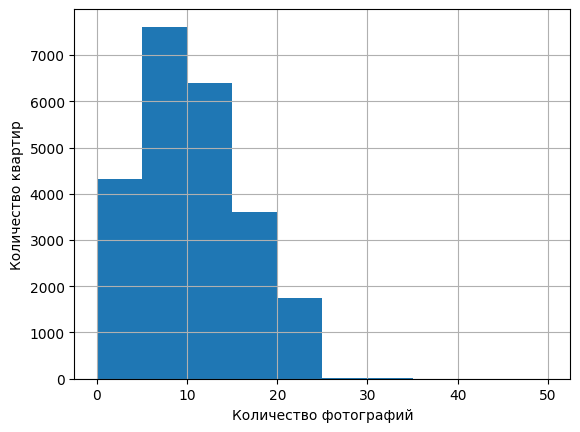

In [9]:
data['total_images'].hist();
plt.xlabel('Количество фотографий')
plt.ylabel('Количество квартир')
plt.show()

В столбце total_images (число фотографий квартиры в объявлении) аномальных значений не выявлено. В основном люди прикладывают до 20 фотографий.

#### Цена

Внимательно посмотрим и обработаем столбец last_price, т.к. это один из важнейших столбцов для дальнейшего анализа.

In [10]:
data['last_price'].sort_values()

8793         12190.0
17456       430000.0
14911       430000.0
16274       440000.0
17676       450000.0
            ...     
15651    300000000.0
1436     330000000.0
14706    401300000.0
19540    420000000.0
12971    763000000.0
Name: last_price, Length: 23699, dtype: float64

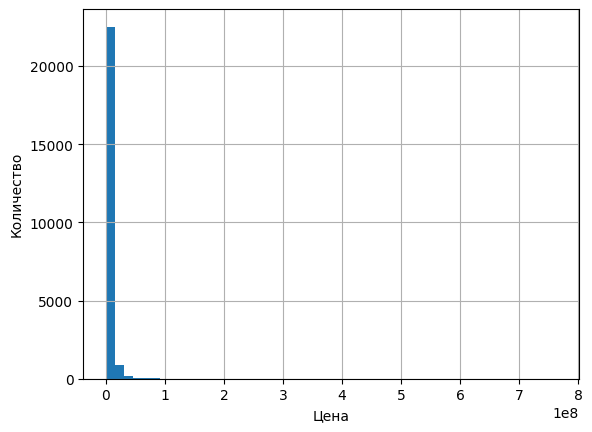

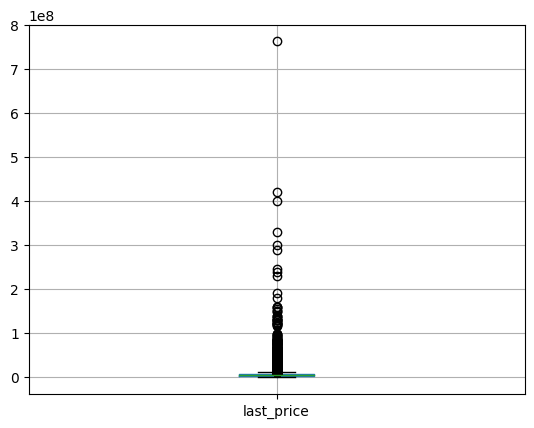

In [11]:
data['last_price'].hist(bins=50)
plt.xlabel('Цена')
plt.ylabel('Количество')
plt.show()
data.boxplot(column='last_price');


In [12]:
pd.set_option('display.float_format', '{:.2f}'.format)
data['last_price'].describe()

count       23699.00
mean      6541548.77
std      10887013.27
min         12190.00
25%       3400000.00
50%       4650000.00
75%       6800000.00
max     763000000.00
Name: last_price, dtype: float64

Вычислим значения, за которыми находятся выбросы в диаграмме размаха.

In [13]:
a = 6800000 + 1.5 * (6800000 - 3400000) 
b = 3400000 - 1.5 * (6800000 - 3400000)
print (a, b)

11900000.0 -1700000.0


In [14]:
data[data['last_price'] > 119000000]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
793,20,135000000.00,310.00,2018-05-22T00:00:00,4,3.30,5.00,250.00,2,NaN,False,False,50.00,NaN,Санкт-Петербург,34159.00,7251.00,2.00,295.00,3.00,190.00,342.00
1026,20,155000000.00,310.00,2018-10-12T00:00:00,5,5.30,3.00,190.00,3,NaN,False,False,63.00,2.00,Санкт-Петербург,24899.00,4785.00,0.00,NaN,1.00,603.00,NaN
1300,14,120000000.00,280.00,2018-07-12T00:00:00,5,4.70,4.00,162.00,3,NaN,False,False,30.00,NaN,Санкт-Петербург,24680.00,4247.00,1.00,464.00,3.00,339.00,225.00
1436,19,330000000.00,190.00,2018-04-04T00:00:00,3,3.50,7.00,95.00,5,NaN,False,False,40.00,NaN,Санкт-Петербург,23011.00,1197.00,3.00,519.00,3.00,285.00,233.00
1928,11,125000000.00,224.50,2017-01-24T00:00:00,4,NaN,4.00,163.50,3,False,False,False,30.00,1.00,Санкт-Петербург,22805.00,2335.00,0.00,NaN,2.00,497.00,174.00
2243,9,130278280.00,304.00,2015-07-24T00:00:00,5,3.11,9.00,NaN,7,NaN,False,False,NaN,0.00,Санкт-Петербург,25593.00,5913.00,2.00,164.00,0.00,NaN,599.00
2536,16,159984000.00,242.40,2015-08-27T00:00:00,4,3.85,9.00,131.00,7,NaN,False,False,20.00,0.00,Санкт-Петербург,21946.00,2242.00,1.00,679.00,1.00,227.00,501.00
3117,19,140000000.00,631.00,2019-03-30T00:00:00,7,NaN,5.00,NaN,5,NaN,False,False,60.00,NaN,Санкт-Петербург,25707.00,4972.00,0.00,NaN,2.00,210.00,NaN
4996,20,124000000.00,124.50,2017-10-12T00:00:00,4,3.00,4.00,67.20,2,False,False,False,20.00,NaN,Санкт-Петербург,20399.00,1722.00,3.00,302.00,3.00,172.00,45.00
5893,3,230000000.00,500.00,2017-05-31T00:00:00,6,NaN,7.00,NaN,7,NaN,False,False,40.00,0.00,Санкт-Петербург,32440.00,5297.00,0.00,NaN,2.00,198.00,50.00


Из 23 тысяч строк датафрейма имеем всего 34 квартиры с ценой более 119 млн рублей. И одна квартира ценой менее 430 000 руб. Удалим выбросы.

In [15]:
data = data[data['last_price'] < 119000000]
data = data.drop(index=8793)

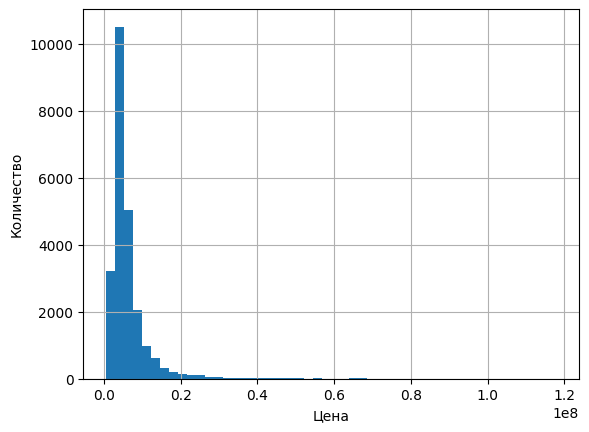

In [16]:
data['last_price'].hist(bins=50)
plt.xlabel('Цена')
plt.ylabel('Количество')
plt.show()

In [17]:
data['last_price'].sort_values()

14911      430000.00
17456      430000.00
16274      440000.00
17676      450000.00
5698       450000.00
            ...     
16590    98000000.00
6621     99000000.00
5631     99000000.00
21923   115490000.00
1188    118000000.00
Name: last_price, Length: 23663, dtype: float64

#### Общая и жилая площадь

Рассмотрим столбцы total_area и living_area.

AxesSubplot(0.125,0.11;0.775x0.77)
AxesSubplot(0.125,0.11;0.775x0.77)


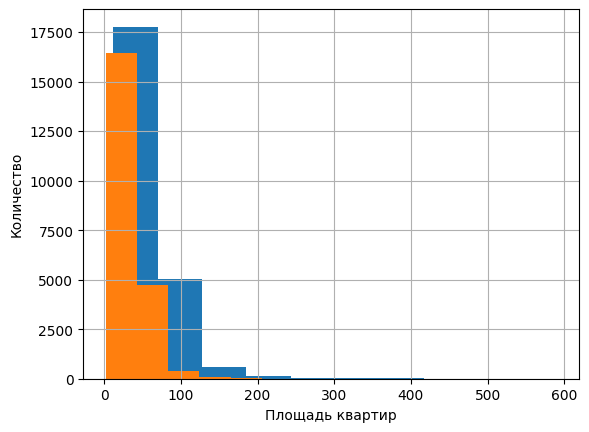

In [18]:
print(data['total_area'].hist());
print(data['living_area'].hist());
plt.xlabel('Площадь квартир');
plt.ylabel('Количество');
plt.show();

Оставим только те квартиры, общая площадь которых не более 350 м2.

In [19]:
data = data[data['total_area'] < 350]

In [20]:
data[['total_area', 'living_area']].corr() #проверим корреляцию между общей и жилой площадью, чтобы принять решение о заполнении пропусков

,total_area,living_area
total_area,1.00,0.94
living_area,0.94,1.00


Заполним пропуски (8%) в столбце living_area. Заполним медианным значением по квартирам с такой же общей площадью.

In [21]:
for d in data['total_area'].unique():
    data.loc[(data['total_area'] == d) & (data['living_area'].isna()), 'living_area'] = \
    data.loc[(data['total_area'] == d), 'living_area'].median()

#### Дата размещения объявлений

Посмотрим на данные по дате размещения объявления. Т.к. эти данные собраны сервисом автоматически, никаких действий с ними предпринимать не нужно, ошибок нет. Данные собраны с 27.11.14 по 03.05.19.

In [22]:
data['first_day_exposition'].sort_values()

10364    2014-11-27T00:00:00
20635    2014-11-27T00:00:00
696      2014-11-27T00:00:00
15857    2014-11-27T00:00:00
617      2014-11-27T00:00:00
                ...         
17872    2019-05-03T00:00:00
13993    2019-05-03T00:00:00
17551    2019-05-03T00:00:00
2178     2019-05-03T00:00:00
14246    2019-05-03T00:00:00
Name: first_day_exposition, Length: 23633, dtype: object

#### Дни от размещения объявления до снятия

Тоже самое касается и столбца days_exposition. В столбце 3181 пропуска, что говорит о том, что 3181 объявлений актуальны. Для замены пропусков информации нет, оставим их.

#### Количество комнат

Перейдем к анализу столбца rooms.

1     8046
2     7938
3     5809
4     1169
5      311
0      196
6       98
7       44
8        9
9        6
10       3
11       2
16       1
14       1
Name: rooms, dtype: int64


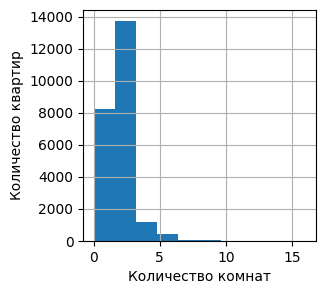

In [23]:
print(data['rooms'].value_counts())
data['rooms'].hist(figsize=(3, 3))
plt.xlabel('Количество комнат')
plt.ylabel('Количество квартир')
plt.show()

In [24]:
data = data[data['rooms'] < 10]

In [25]:
data[data['rooms'] == 0]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
144,1,2450000.00,27.00,2017-03-30T00:00:00,0,NaN,24.00,15.50,2,NaN,True,False,NaN,2.00,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,181.00
349,4,2320000.00,25.00,2017-09-27T00:00:00,0,NaN,14.00,17.00,1,NaN,False,True,NaN,0.00,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,45.00
440,8,2480000.00,27.11,2018-03-12T00:00:00,0,NaN,17.00,24.75,4,NaN,True,False,NaN,2.00,Санкт-Петербург,38171.00,15015.00,0.00,NaN,2.00,982.00,64.00
508,0,3375000.00,34.40,2017-03-28T00:00:00,0,NaN,26.00,24.30,19,NaN,False,True,NaN,1.00,посёлок Парголово,53115.00,19292.00,0.00,NaN,1.00,593.00,430.00
608,2,1850000.00,25.00,2019-02-20T00:00:00,0,NaN,10.00,17.00,7,NaN,True,False,NaN,NaN,посёлок Шушары,NaN,NaN,NaN,NaN,NaN,NaN,29.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23210,7,3200000.00,26.00,2017-09-01T00:00:00,0,NaN,25.00,18.00,16,NaN,True,False,NaN,0.00,Санкт-Петербург,11405.00,13222.00,0.00,NaN,1.00,623.00,14.00
23442,0,2500000.00,27.70,2017-09-28T00:00:00,0,NaN,24.00,18.00,4,NaN,False,True,NaN,2.00,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,4.00
23554,15,3350000.00,26.00,2018-09-07T00:00:00,0,NaN,19.00,17.38,8,NaN,True,False,NaN,NaN,Санкт-Петербург,18090.00,17092.00,0.00,NaN,2.00,112.00,31.00
23592,10,1450000.00,29.00,2017-11-11T00:00:00,0,NaN,9.00,18.00,8,NaN,False,True,NaN,2.00,Никольское,NaN,NaN,NaN,NaN,NaN,NaN,82.00


В датафрейме 197 строк, в которых проставлено нулевое количество комнат. Вероятно, часть из них - студии, а часть имеют свободную планировку. Для дальнейшего анализа оставим нули в этих категориях, таких квартир всего 197 из всей выборки (менее 1%). Но сначала проверим, нет ли аномальных значений в столбцах studio и open_plan.

In [26]:
print(data['studio'].unique())
data['open_plan'].unique()

[False  True]


array([False,  True])

Аномальных значений нет.

In [27]:
data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.00,108.00,2019-03-07T00:00:00,3,2.70,16.00,51.00,8,NaN,False,False,25.00,NaN,Санкт-Петербург,18863.00,16028.00,1.00,482.00,2.00,755.00,NaN
1,7,3350000.00,40.40,2018-12-04T00:00:00,1,NaN,11.00,18.60,1,NaN,False,False,11.00,2.00,посёлок Шушары,12817.00,18603.00,0.00,NaN,0.00,NaN,81.00
2,10,5196000.00,56.00,2015-08-20T00:00:00,2,NaN,5.00,34.30,4,NaN,False,False,8.30,0.00,Санкт-Петербург,21741.00,13933.00,1.00,90.00,2.00,574.00,558.00
3,0,64900000.00,159.00,2015-07-24T00:00:00,3,NaN,14.00,95.00,9,NaN,False,False,NaN,0.00,Санкт-Петербург,28098.00,6800.00,2.00,84.00,3.00,234.00,424.00
4,2,10000000.00,100.00,2018-06-19T00:00:00,2,3.03,14.00,32.00,13,NaN,False,False,41.00,NaN,Санкт-Петербург,31856.00,8098.00,2.00,112.00,1.00,48.00,121.00
5,10,2890000.00,30.40,2018-09-10T00:00:00,1,NaN,12.00,14.40,5,NaN,False,False,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.00
6,6,3700000.00,37.30,2017-11-02T00:00:00,1,NaN,26.00,10.60,6,NaN,False,False,14.40,1.00,посёлок Парголово,52996.00,19143.00,0.00,NaN,0.00,NaN,155.00
7,5,7915000.00,71.60,2019-04-18T00:00:00,2,NaN,24.00,44.30,22,NaN,False,False,18.90,2.00,Санкт-Петербург,23982.00,11634.00,0.00,NaN,0.00,NaN,NaN
8,20,2900000.00,33.16,2018-05-23T00:00:00,1,NaN,27.00,15.43,26,NaN,False,False,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.00
9,18,5400000.00,61.00,2017-02-26T00:00:00,3,2.50,9.00,43.60,7,NaN,False,False,6.50,2.00,Санкт-Петербург,50898.00,15008.00,0.00,NaN,0.00,NaN,289.00


In [28]:
data['rooms'].value_counts()

1    8046
2    7938
3    5809
4    1169
5     311
0     196
6      98
7      44
8       9
9       6
Name: rooms, dtype: int64

#### Высота потолков

Перейдем к анализу столбца ceiling_height. Высота потолка вряд ли может быть менее 2 метров и более 5 метров, отсортируем все данные, которые не соответствуют этим условиям, чтобы изучить аномальные значения.

In [29]:
data[(data['ceiling_height'] < 2) | (data['ceiling_height'] > 5)]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
355,17,3600000.00,55.20,2018-07-12T00:00:00,2,25.00,5.00,32.00,2,False,False,False,NaN,2.00,Гатчина,NaN,NaN,NaN,NaN,NaN,NaN,259.00
464,15,66571000.00,280.30,2015-06-11T00:00:00,6,5.20,8.00,159.50,7,NaN,False,False,21.10,0.00,Санкт-Петербург,26316.00,6655.00,3.00,187.00,1.00,616.00,578.00
3148,14,2900000.00,75.00,2018-11-12T00:00:00,3,32.00,3.00,53.00,2,NaN,False,False,8.00,NaN,Волхов,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3474,3,1400000.00,30.00,2018-03-16T00:00:00,1,8.00,5.00,15.30,2,False,False,False,7.30,NaN,деревня Нурма,NaN,NaN,NaN,NaN,NaN,NaN,125.00
4643,0,4300000.00,45.00,2018-02-01T00:00:00,2,25.00,9.00,30.00,2,NaN,False,False,7.00,1.00,Санкт-Петербург,12016.00,13256.00,1.00,658.00,1.00,331.00,181.00
4876,7,3000000.00,25.00,2017-09-27T00:00:00,0,27.00,25.00,17.00,17,NaN,False,True,NaN,2.00,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,28.00
5076,0,3850000.00,30.50,2018-10-03T00:00:00,1,24.00,5.00,19.50,1,True,False,False,5.50,NaN,Санкт-Петербург,29686.00,8389.00,3.00,397.00,1.00,578.00,7.00
5246,0,2500000.00,54.00,2017-10-13T00:00:00,2,27.00,5.00,30.00,3,NaN,False,False,9.00,2.00,деревня Мины,NaN,NaN,NaN,NaN,NaN,NaN,540.00
5669,4,4400000.00,50.00,2017-08-08T00:00:00,2,26.00,9.00,21.30,3,NaN,False,False,7.00,2.00,Санкт-Петербург,28981.00,10912.00,1.00,305.00,0.00,NaN,267.00
5712,5,1500000.00,42.80,2017-08-14T00:00:00,2,1.20,2.00,27.50,1,NaN,False,False,5.20,NaN,городской посёлок Мга,NaN,NaN,NaN,NaN,NaN,NaN,248.00


В нашей базе данных 37 строк с картирами, высота потолков в которых менее 2 и более 5 метров. Заметно, что в некоторых данных высоту потолков можно поправить переносом запятой (судя по всему, ошибка в записи). Для остальных строк поставим пропуск.

In [30]:
data.loc[data['ceiling_height'] <= 2, 'ceiling_height'] = float('Nan')
data.loc[data['ceiling_height'] > 20, 'ceiling_height'] = data['ceiling_height'] / 10
data.loc[data['ceiling_height'] > 5, 'ceiling_height'] = float('Nan')
data.loc[data['ceiling_height'] == 100, 'ceiling_height'] = float('Nan')

Избавились от всех аномальных значений, далее поработаем с пропусками. Можно сделать предположение, что высота потолков в домах одного ценового диапазона и одной этажности примерно одинаковая. Заменим все пропуски мединным значением потолка по домам такого же класса и такой же этажности. Для этого поработаем с данными floors_total и last_price.

In [31]:
print('Все уникальные значения этажности:', data['floors_total'].unique())
print('Всего пропусков в этажности:', data['floors_total'].isna().sum())

Все уникальные значения этажности: [16. 11.  5. 14. 12. 26. 24. 27.  9.  6. 17. 25.  3. 23. 19. 18.  4. 22.
  8.  2. 10.  7. 13. 15. nan 20. 28. 36. 21. 35. 34. 60.  1. 29. 33. 52.
 37.]
Всего пропусков в этажности: 86


Аномальных значений не выявлено, имеется 86 пропусков, для заполнения которых данных не достаточно. Пропусков всего 0,36% от всех значений, поставим на их место медианное значение всех значений floors_total, что не должно повлиять на выводы. Тем самым избавимся от пустых значений в этом столбце.

In [32]:
data['floors_total'] = data['floors_total'].fillna(data['floors_total'].median().round(0))

После замены сделаем проверку, не превышает ли этаж, на котором квартира общую этажность. Посчитаем количество строк, где это выполняется.

In [33]:
data[data['floors_total'] < data['floor']]['floors_total'].count()

37

Тогда заменим такие места на этаж квартиры.


In [34]:
data.loc[data['floors_total'] < data['floor'], 'floor'] = data['floor']

Добавим в таблицу новый столбец price_m2.

In [35]:
data['price_m2'] = (data['last_price'] / data['total_area']).round(1)

In [36]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_m2
0,20,13000000.00,108.00,2019-03-07T00:00:00,3,2.70,16.00,51.00,8,NaN,False,False,25.00,NaN,Санкт-Петербург,18863.00,16028.00,1.00,482.00,2.00,755.00,NaN,120370.40
1,7,3350000.00,40.40,2018-12-04T00:00:00,1,NaN,11.00,18.60,1,NaN,False,False,11.00,2.00,посёлок Шушары,12817.00,18603.00,0.00,NaN,0.00,NaN,81.00,82920.80
2,10,5196000.00,56.00,2015-08-20T00:00:00,2,NaN,5.00,34.30,4,NaN,False,False,8.30,0.00,Санкт-Петербург,21741.00,13933.00,1.00,90.00,2.00,574.00,558.00,92785.70
3,0,64900000.00,159.00,2015-07-24T00:00:00,3,NaN,14.00,95.00,9,NaN,False,False,NaN,0.00,Санкт-Петербург,28098.00,6800.00,2.00,84.00,3.00,234.00,424.00,408176.10
4,2,10000000.00,100.00,2018-06-19T00:00:00,2,3.03,14.00,32.00,13,NaN,False,False,41.00,NaN,Санкт-Петербург,31856.00,8098.00,2.00,112.00,1.00,48.00,121.00,100000.00


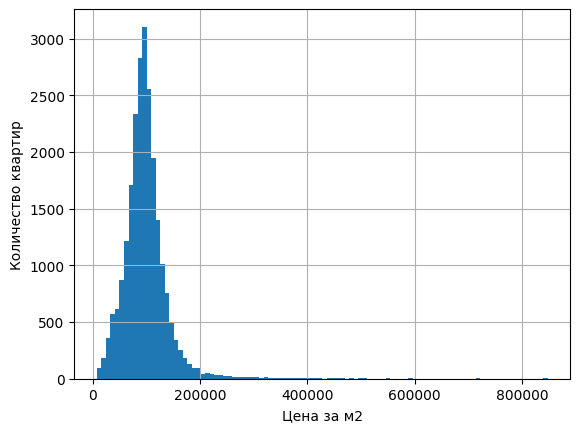

In [37]:
data['price_m2'].hist(bins=100);
plt.xlabel('Цена за м2')
plt.ylabel('Количество квартир')
plt.show()

In [38]:
data[['price_m2','ceiling_height', 'floors_total', 'kitchen_area', 'total_area', 'last_price', 'cityCenters_nearest']].corr() 
#проверяем корреляцию нового столбца с другими столбцами, с которыми теоретически может быть связь

,price_m2,ceiling_height,floors_total,kitchen_area,total_area,last_price,cityCenters_nearest
price_m2,1.00,0.37,0.18,0.39,0.26,0.73,-0.36
ceiling_height,0.37,1.00,-0.09,0.41,0.49,0.48,-0.37
floors_total,0.18,-0.09,1.00,0.18,-0.07,0.01,0.02
kitchen_area,0.39,0.41,0.18,1.00,0.58,0.58,-0.19
total_area,0.26,0.49,-0.07,0.58,1.00,0.75,-0.24
last_price,0.73,0.48,0.01,0.58,0.75,1.00,-0.30
cityCenters_nearest,-0.36,-0.37,0.02,-0.19,-0.24,-0.30,1.00


Чтобы заполнить пропуски в высоте потолков, разделим недвижимость на несколько категорий по цене за м2.
По усредненной информации нескольких консалтинговых центров ("Петербургская Недвижимость", "Glorax Developmen", ГК «Полис Групп») поделить недвижимость Санкт-Петербурга можно на такие сегменты (по цене за м2):
<br>
<br>
- `Econom`: до 110 тыс руб за м2
<br>
- `Comfort`: от 110 до 160 тыс руб за м2
<br>
- `Business`: от 160 тыс руб до 300 тыс руб за м2
<br>
- `Elite`: от 300 тыс руб за м2

In [39]:
def categorize_realty(price_m2):
    if price_m2<110000:
        return 'Econom'
    if price_m2<160000:
        return 'Comfort'
    if price_m2<=300000:
        return 'Business'
    return 'Elite'

In [40]:
data['realty_category'] = data['price_m2'].apply(categorize_realty)

In [41]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_m2,realty_category
0,20,13000000.00,108.00,2019-03-07T00:00:00,3,2.70,16.00,51.00,8,NaN,False,False,25.00,NaN,Санкт-Петербург,18863.00,16028.00,1.00,482.00,2.00,755.00,NaN,120370.40,Comfort
1,7,3350000.00,40.40,2018-12-04T00:00:00,1,NaN,11.00,18.60,1,NaN,False,False,11.00,2.00,посёлок Шушары,12817.00,18603.00,0.00,NaN,0.00,NaN,81.00,82920.80,Econom
2,10,5196000.00,56.00,2015-08-20T00:00:00,2,NaN,5.00,34.30,4,NaN,False,False,8.30,0.00,Санкт-Петербург,21741.00,13933.00,1.00,90.00,2.00,574.00,558.00,92785.70,Econom
3,0,64900000.00,159.00,2015-07-24T00:00:00,3,NaN,14.00,95.00,9,NaN,False,False,NaN,0.00,Санкт-Петербург,28098.00,6800.00,2.00,84.00,3.00,234.00,424.00,408176.10,Elite
4,2,10000000.00,100.00,2018-06-19T00:00:00,2,3.03,14.00,32.00,13,NaN,False,False,41.00,NaN,Санкт-Петербург,31856.00,8098.00,2.00,112.00,1.00,48.00,121.00,100000.00,Econom


Проверим адекватность распеределения категорий гистограммой.

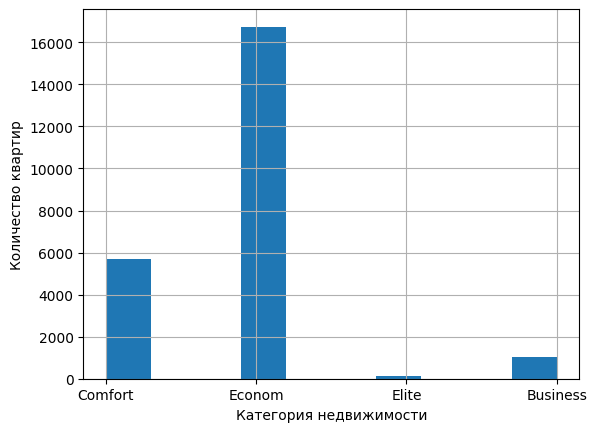

In [42]:
data['realty_category'].hist();
plt.xlabel('Категория недвижимости')
plt.ylabel('Количество квартир')
plt.show()

Сделаем предположение, что дома одного ценового диапазона и одной этажности имеют примерно одинаковую высоту потолка, и заполним пропуски в ceiling_height медианным значением.

In [43]:
for d in data['floors_total'].unique():
    for i in data['realty_category'].unique():
        data.loc[(data['floors_total'] == d) & (data['realty_category'] == i) & (data['ceiling_height'].isna()), 'ceiling_height'] = \
        data.loc[((data['floors_total'] == d) & (data['realty_category'] == i)), 'ceiling_height'].median()

In [44]:
data['ceiling_height'].isna().sum()

7

Удалось заполнить большую часть пропусков, осталось менее 1% от первоначального значения.

#### Аапартаменты

Перейдем к анализу столбца is_apartment. В нем мы видим самый большой процент попусков (88.29%). 

In [45]:
print('Список уникальных значений:', data['is_apartment'].unique())
print('Значений False:', data.loc[data.loc[:,'is_apartment'] == False]['is_apartment'].count())
print('Значений True:', data.loc[data.loc[:,'is_apartment'] == True]['is_apartment'].count())
print('Пропущенных значений:', data['is_apartment'].isna().sum())


Список уникальных значений: [nan False True]
Значений False: 2720
Значений True: 49
Пропущенных значений: 20857


В базе данных всего 50 квартир, в которых стоит статус "Апартаменты". И 2721 квартир без данного статуса. Можно предположить, что порядка 1,8% от всех квартир - Апартаменты. Данных недостаточно, чтобы заполнить 21 тысячу пропусков. Если бы для дальнейшего анализа нам нужна бы была эта информация, мы бы заполнили все пропуски значением False и в дальнейшем понимали, что порядка 2% заполнено с ошибкой. Но т.к. для данного задания анализ этого статуса не потребуется, оставим пропуски.

Скорее всего ошибка возникла из-за невнимательного заполнения анкеты клиентами. Судя по такому большому количеству пропусков (почти 90%), эта ячейка в анкете не считывается пользователями, как действительно важная и необходимая к заполнению.

#### Площадь кухни

Перейдем к анализу столбца kitchen_area.

In [46]:
print(data['kitchen_area'].min())
data['kitchen_area'].max()

1.3


107.0

In [47]:
data['kitchen_area'].sort_values()

20217   1.30
11033   2.00
6262    2.00
906     2.00
16367   2.00
        ... 
23655    NaN
23663    NaN
23670    NaN
23679    NaN
23696    NaN
Name: kitchen_area, Length: 23626, dtype: float64

In [48]:
data[['kitchen_area', 'total_area', 'rooms', 'floors_total', 'living_area']].corr() 
#проверяем корреляцию у значений, логически связанных между собой

,kitchen_area,total_area,rooms,floors_total,living_area
kitchen_area,1.00,0.58,0.24,0.18,0.38
total_area,0.58,1.00,0.78,-0.07,0.94
rooms,0.24,0.78,1.00,-0.23,0.85
floors_total,0.18,-0.07,-0.23,1.00,-0.17
living_area,0.38,0.94,0.85,-0.17,1.00


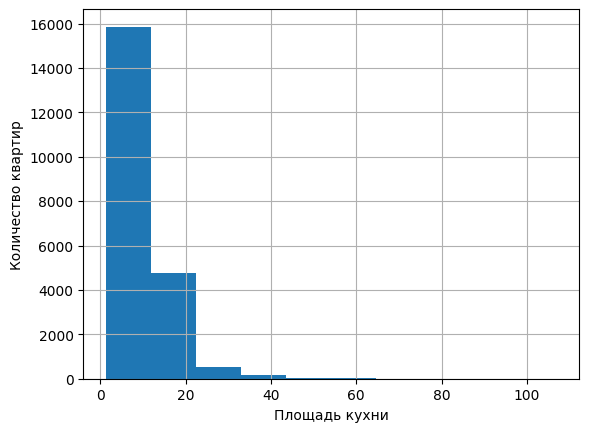

In [49]:
data['kitchen_area'].hist();
plt.xlabel('Площадь кухни')
plt.ylabel('Количество квартир')
plt.show()

Заполним пропуск, используя два разных способа и сравним результаты.

**1 способ**: Заполним пропуски медианным значением по квартирам с такой же общей площадью. Запишем результат в новый столбец kitchen_area1.

In [50]:
data['kitchen_area1'] = data['kitchen_area'].fillna(data['kitchen_area'])

for d in data['total_area'].unique():
    data.loc[(data['total_area'] == d) & (data['kitchen_area1'].isna()), 'kitchen_area1'] = \
    data.loc[(data['total_area'] == d), 'kitchen_area1'].median()


**2 способ**: Найдем соотношение средней кухонной площади к средней общей площади и используем полученное значение для замены пропусков. Запишем результат в новый столбец kitchen_area2.

In [51]:
data['kitchen_area2'] = data['kitchen_area'].fillna(data['kitchen_area'])
ratio = data['kitchen_area'].mean()/data['total_area'].mean()
data['kitchen_area2'] = data['kitchen_area2'].fillna(data['total_area']*ratio)

Сравним результаты:

In [52]:
print(data['kitchen_area1'].describe())
data['kitchen_area2'].describe()

count   23428.00
mean       10.38
std         5.51
min         1.30
25%         7.00
50%         9.00
75%        11.80
max       107.00
Name: kitchen_area1, dtype: float64


count   23626.00
mean       10.42
std         5.66
min         1.30
25%         7.00
50%         9.00
75%        12.00
max       107.00
Name: kitchen_area2, dtype: float64

Результаты практически идентичны, заполним kitchen_area данными из kitchen_area1, и удалим два лишних столбца kitchen_area1 и kitchen_area2.

In [53]:
data['kitchen_area'] = data['kitchen_area1']

In [54]:
data = data.drop(['kitchen_area1', 'kitchen_area2'], axis=1) #удаляем вспомогательные столбцы

In [55]:
data['kitchen_area'].isna().sum()

198

Сократили количество пропусков в площади кухни с 2278 до 203 значений.

#### Балконы

Проанализируем столбце balcony. Считаем, что если балконы не указаны, то значит их в квартире нет. 

In [56]:
data['balcony'] = data['balcony'].fillna(0)

In [57]:
print('Количество пропусков в столбце balcony:', data['balcony'].isna().sum())

Количество пропусков в столбце balcony: 0


#### Населенный пункт

В столбце locality_name имеем 49 пропусков. Так как это важнеший элемент нашего будущего анализа, удалим все строки без указания города.

In [58]:
data = data.dropna(subset=['locality_name'])

In [59]:
print('Количество пропусков в столбце locality_name:', data['locality_name'].isna().sum())

Количество пропусков в столбце locality_name: 0


#### Аэропорты, парки, водоемы, центр города

Переходим к работе с картографическими ячейками, которые были заполнены сервисом автоматически: airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest.

In [60]:
print(data['parks_around3000'].unique())
print(data['ponds_around3000'].unique())

[ 1.  0.  2. nan  3.]
[ 2.  0.  3.  1. nan]


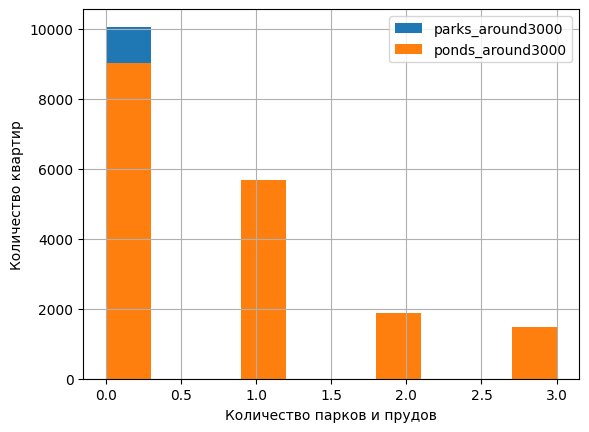

In [61]:
data['parks_around3000'].hist(label='parks_around3000')
data['ponds_around3000'].hist(label='ponds_around3000')
plt.xlabel('Количество парков и прудов')
plt.ylabel('Количество квартир')
plt.legend()
plt.show()

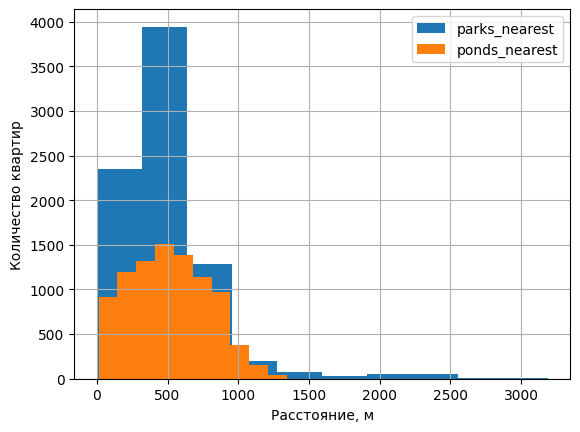

In [62]:
data['parks_nearest'].hist(label='parks_nearest')
data['ponds_nearest'].hist(label='ponds_nearest');
plt.xlabel('Расстояние, м')
plt.ylabel('Количество квартир')
plt.legend()
plt.show()

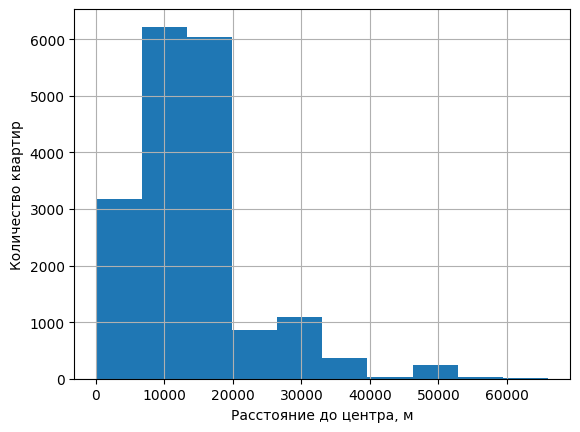

In [63]:
data['cityCenters_nearest'].hist();
plt.xlabel('Расстояние до центра, м')
plt.ylabel('Количество квартир')
plt.show()

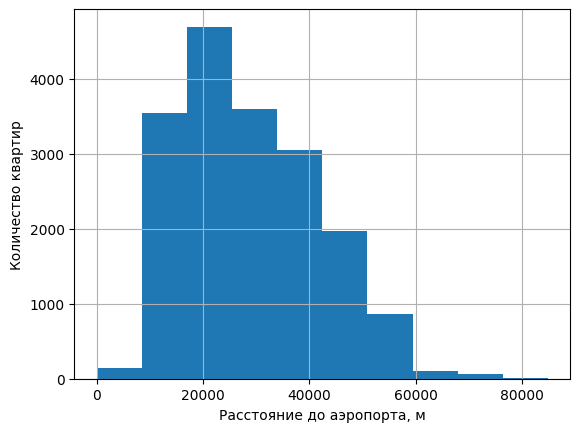

In [64]:
data['airports_nearest'].hist();
plt.xlabel('Расстояние до аэропорта, м')
plt.ylabel('Количество квартир')
plt.show()

По гистограммам мы видим, что данные по паркам включают парки в радиусе до 3 км, а пруды - в радуисе 1,5 км. 
При этом и значения parks/ponds_around3000 и parks/ponds_nearest имеют примерно совпадающее попарно количество пропусков (23% и 65%). Тоже самое и с airports_nearest и cityCenters_nearest: данные не проставлены в 23% строк.  Стоит пообщаться с сотрудникам сервиса, чтобы понять природу этих пропусков и понять, чем мы можем их заменить. Пока оставляем данные в том виде, как они есть.

#### Типы объектов

Поработаем с типами объектов. Судя по info(), есть несколько столбцов с неверным типом объекта, что может помешать нам в дальнейшем анализе.

first_day_exposition должен содержаться в себе даты (тип datetime), однако содержит тип object. 

In [65]:
data['first_day_exposition']

0        2019-03-07T00:00:00
1        2018-12-04T00:00:00
2        2015-08-20T00:00:00
3        2015-07-24T00:00:00
4        2018-06-19T00:00:00
                ...         
23694    2017-03-21T00:00:00
23695    2018-01-15T00:00:00
23696    2018-02-11T00:00:00
23697    2017-03-28T00:00:00
23698    2017-07-21T00:00:00
Name: first_day_exposition, Length: 23577, dtype: object

In [66]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%dT%H:%M:%S')            

Число дней размещения объявления days_exposition, число этажей floors_total, количество балконов balcony, количество парков parks_around3000 и водоемов ponds_around3000 могут быть только целочисленными, поэтому поменяем тип float64 на int64 без изменения пустых значений.

In [67]:
data['days_exposition'] = (data['days_exposition']).round(0) #округляем значения дней, т.к. десятичные части не будут важны для анализа

In [68]:
data['days_exposition'] = data['days_exposition'].astype('Int64')
data['floors_total'] = data['floors_total'].astype('Int64')
data['balcony'] = data['balcony'].astype('Int64')
data['parks_around3000'] = data['parks_around3000'].astype('Int64')
data['ponds_around3000'] = data['ponds_around3000'].astype('Int64')

In [69]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_m2,realty_category
0,20,13000000.00,108.00,2019-03-07,3,2.70,16,51.00,8,NaN,False,False,25.00,0,Санкт-Петербург,18863.00,16028.00,1,482.00,2,755.00,<NA>,120370.40,Comfort
1,7,3350000.00,40.40,2018-12-04,1,2.70,11,18.60,1,NaN,False,False,11.00,2,посёлок Шушары,12817.00,18603.00,0,NaN,0,NaN,81,82920.80,Econom
2,10,5196000.00,56.00,2015-08-20,2,2.54,5,34.30,4,NaN,False,False,8.30,0,Санкт-Петербург,21741.00,13933.00,1,90.00,2,574.00,558,92785.70,Econom
3,0,64900000.00,159.00,2015-07-24,3,3.30,14,95.00,9,NaN,False,False,15.00,0,Санкт-Петербург,28098.00,6800.00,2,84.00,3,234.00,424,408176.10,Elite
4,2,10000000.00,100.00,2018-06-19,2,3.03,14,32.00,13,NaN,False,False,41.00,0,Санкт-Петербург,31856.00,8098.00,2,112.00,1,48.00,121,100000.00,Econom


#### Названия населенных пунктов

Поработаем с неявными дубликатами в названиях населенных пунктов.

In [70]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [71]:
display(data['locality_name'].value_counts())

Санкт-Петербург                        15650
посёлок Мурино                           522
посёлок Шушары                           440
Всеволожск                               398
Пушкин                                   367
                                       ...  
поселок городского типа Кондратьево        1
коттеджный посёлок Лесное                  1
деревня Вахнова Кара                       1
посёлок Платформа 69-й километр            1
городской посёлок Свирьстрой               1
Name: locality_name, Length: 364, dtype: int64

Приведем все названия к нижнему регистру и заменим неявные дубликаты.

In [72]:
data['locality_name'] = data['locality_name'].str.lower()
data['locality_name'] = data['locality_name'].replace('ё', 'е', regex = True)
data['locality_name'] = data['locality_name'].replace('поселок ', '', regex = True)
data['locality_name'] = data['locality_name'].replace('поселок городского типа', '', regex = True)
data['locality_name'] = data['locality_name'].replace('городской поселок', '', regex = True)
data['locality_name'] = data['locality_name'].replace('деревня', '', regex = True)
data['locality_name'] = data['locality_name'].replace('коттеджный поселок', '', regex = True)
data['locality_name'] = data['locality_name'].replace('садоводческое некоммерческое товарищество', '', regex = True)
data['locality_name'] = data['locality_name'].replace('садоводческое товарищество', '', regex = True)
data['locality_name'] = data['locality_name'].replace('садовое товарищество', '', regex = True)
data['locality_name'] = data['locality_name'].replace('село', '', regex = True)
data['locality_name'] = data['locality_name'].replace('при железнодорожной станции', '', regex = True)
data['locality_name'] = data['locality_name'].replace('городского типа', '', regex = True)
data['locality_name'] = data['locality_name'].replace('городской', '', regex = True)
data['locality_name'] = data['locality_name'].str.lstrip() #удаляем пробелы вначале строк
data['locality_name']  = data['locality_name'].str.title() # делаем первые буквы заглавными

In [73]:
data['locality_name'].value_counts()

Санкт-Петербург    15650
Мурино               590
Кудрово              472
Шушары               440
Всеволожск           398
                   ...  
Тесово-4               1
Гладкое                1
Малая Романовка        1
Шпаньково              1
Пижма                  1
Name: locality_name, Length: 309, dtype: int64

**Предобработка данных закончена.** Мы удалили пустые значения там, где это было возможно, поменяли типы данных, устранили неявные дубликаты, устранили выбросы. Перейдем к добавлению новый столбцов, которые нужны нам для дальнейшего анализа.

### Добавим необходимые для анализа столбцов в таблицу.

Добавляем столбец с днем недели публикации объявления: 0 - понедельник, 1 вторник и так далее.

In [74]:
data['exposition_weekday'] = data['first_day_exposition'].dt.weekday

Добавляем столбец с месяцем публикации объявления.

In [75]:
data['exposition_month'] = data['first_day_exposition'].dt.month

Добавляем столбец с годом публикации объявления.

In [76]:
data['exposition_year'] = data['first_day_exposition'].dt.year

Добавляем столбец с расстоянием до центра в километрах.

In [77]:
data['cityCenters_nearest_km'] = (data['cityCenters_nearest'] / 1000).round(2)

Добавляем столбец с типом этажа квартиры (значения — «первый», «последний», «другой»).

In [78]:
def floor_type(row):
    floor = row['floor']
    floors_total = row['floors_total']
    
    if floor == 1:
        return 'первый'
    if floor == floors_total:
        return 'последний'
    return 'другой'

data['floor_type'] = data.apply(floor_type, axis=1)

Посмотрим на получившуюся таблицу с новыми столбцами.

In [79]:
data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_m2,realty_category,exposition_weekday,exposition_month,exposition_year,cityCenters_nearest_km,floor_type
0,20,13000000.00,108.00,2019-03-07,3,2.70,16,51.00,8,NaN,False,False,25.00,0,Санкт-Петербург,18863.00,16028.00,1,482.00,2,755.00,<NA>,120370.40,Comfort,3,3,2019,16.03,другой
1,7,3350000.00,40.40,2018-12-04,1,2.70,11,18.60,1,NaN,False,False,11.00,2,Шушары,12817.00,18603.00,0,NaN,0,NaN,81,82920.80,Econom,1,12,2018,18.60,первый
2,10,5196000.00,56.00,2015-08-20,2,2.54,5,34.30,4,NaN,False,False,8.30,0,Санкт-Петербург,21741.00,13933.00,1,90.00,2,574.00,558,92785.70,Econom,3,8,2015,13.93,другой
3,0,64900000.00,159.00,2015-07-24,3,3.30,14,95.00,9,NaN,False,False,15.00,0,Санкт-Петербург,28098.00,6800.00,2,84.00,3,234.00,424,408176.10,Elite,4,7,2015,6.80,другой
4,2,10000000.00,100.00,2018-06-19,2,3.03,14,32.00,13,NaN,False,False,41.00,0,Санкт-Петербург,31856.00,8098.00,2,112.00,1,48.00,121,100000.00,Econom,1,6,2018,8.10,другой
5,10,2890000.00,30.40,2018-09-10,1,2.65,12,14.40,5,NaN,False,False,9.10,0,Янино-1,NaN,NaN,<NA>,NaN,<NA>,NaN,55,95065.80,Econom,0,9,2018,NaN,другой
6,6,3700000.00,37.30,2017-11-02,1,2.60,26,10.60,6,NaN,False,False,14.40,1,Парголово,52996.00,19143.00,0,NaN,0,NaN,155,99195.70,Econom,3,11,2017,19.14,другой
7,5,7915000.00,71.60,2019-04-18,2,2.75,24,44.30,22,NaN,False,False,18.90,2,Санкт-Петербург,23982.00,11634.00,0,NaN,0,NaN,<NA>,110544.70,Comfort,3,4,2019,11.63,другой
8,20,2900000.00,33.16,2018-05-23,1,2.65,27,15.43,26,NaN,False,False,8.81,0,Мурино,NaN,NaN,<NA>,NaN,<NA>,NaN,189,87454.80,Econom,2,5,2018,NaN,другой
9,18,5400000.00,61.00,2017-02-26,3,2.50,9,43.60,7,NaN,False,False,6.50,2,Санкт-Петербург,50898.00,15008.00,0,NaN,0,NaN,289,88524.60,Econom,6,2,2017,15.01,другой


Переходим к исследовательскому анализу данных.

### Проведем исследовательский анализ данных.

Построим гистограммы по необходимым для анализа столбцам.

#### Общая площадь

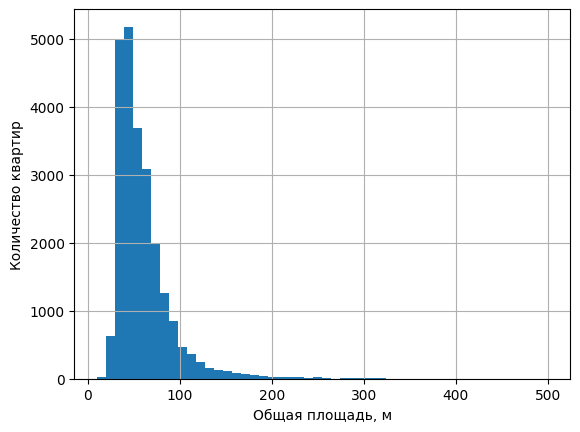

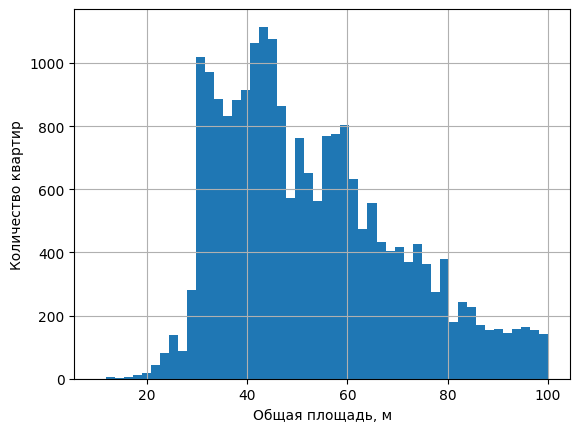

In [80]:
data['total_area'].hist(bins = 50,range = (10,500)) #общая площадь
plt.xlabel('Общая площадь, м')
plt.ylabel('Количество квартир')
plt.show()
data['total_area'].hist(bins = 50,range = (10,100));
plt.xlabel('Общая площадь, м')
plt.ylabel('Количество квартир')
plt.show()

Распределение нормальное, аномальных значений и выбросов не наблюдается. Самый распространеный метраж квартир - однушки около 40 м2.

#### Жилая площадь

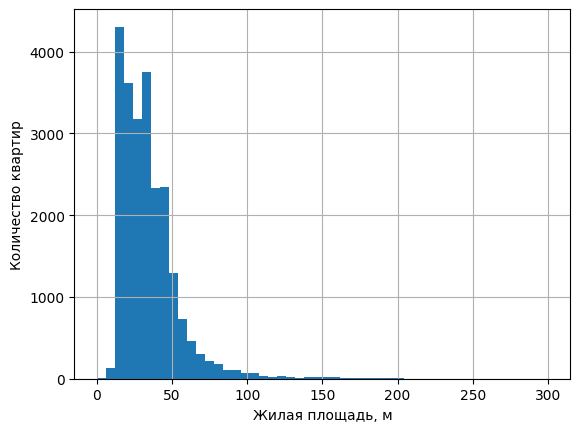

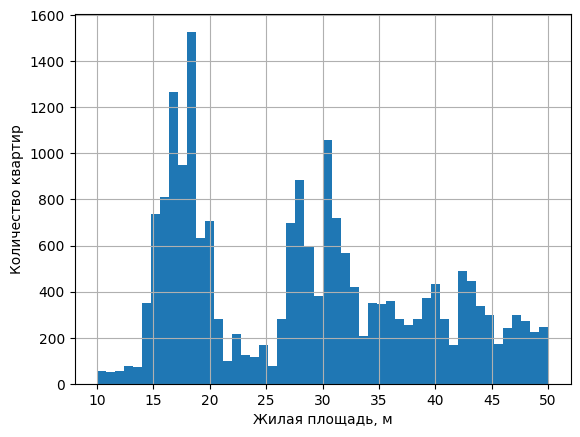

In [81]:
data['living_area'].hist(bins = 50, range = (0,300)) #жилая площадь
plt.xlabel('Жилая площадь, м')
plt.ylabel('Количество квартир')
plt.show()
data['living_area'].hist(bins = 50, range = (10,50)) ;
plt.xlabel('Жилая площадь, м')
plt.ylabel('Количество квартир')
plt.show()

Распределение мультимодальное, видим провал в районе 23-27 м2. Посмотрим на данные, чтобы понять, с чем может быть связан этот провал.

In [82]:
data[(data['living_area'] > 17) & (data['living_area'] < 19)]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_m2,realty_category,exposition_weekday,exposition_month,exposition_year,cityCenters_nearest_km,floor_type
1,7,3350000.00,40.40,2018-12-04,1,2.70,11,18.60,1,NaN,False,False,11.00,2,Шушары,12817.00,18603.00,0,NaN,0,NaN,81,82920.80,Econom,1,12,2018,18.60,первый
23,11,2950000.00,32.00,2016-10-29,1,2.60,9,17.70,9,NaN,False,False,6.10,0,Санкт-Петербург,15414.00,14211.00,2,517.00,1,190.00,615,92187.50,Econom,5,10,2016,14.21,последний
30,12,2200000.00,32.80,2018-02-19,1,2.55,9,17.50,2,NaN,False,False,7.20,0,Коммунар,NaN,NaN,<NA>,NaN,<NA>,NaN,63,67073.20,Econom,0,2,2018,NaN,другой
44,13,5350000.00,40.00,2018-11-18,1,2.75,22,18.00,3,NaN,False,False,10.00,1,Санкт-Петербург,30471.00,11603.00,1,620.00,1,1152.00,<NA>,133750.00,Comfort,6,11,2018,11.60,другой
49,1,3050000.00,30.80,2018-11-22,1,2.50,9,18.00,7,NaN,False,False,6.00,0,Санкт-Петербург,45341.00,16603.00,1,675.00,0,NaN,<NA>,99026.00,Econom,3,11,2018,16.60,другой
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23671,3,3450000.00,35.30,2017-04-14,1,2.50,9,17.50,4,False,False,False,7.50,2,Санкт-Петербург,21435.00,15261.00,1,334.00,1,232.00,21,97733.70,Econom,4,4,2017,15.26,другой
23677,8,2450000.00,35.00,2018-10-26,1,2.60,5,18.00,4,NaN,False,False,9.60,0,Всеволожск,NaN,NaN,<NA>,NaN,<NA>,NaN,28,70000.00,Econom,4,10,2018,NaN,другой
23685,15,2490000.00,31.00,2019-01-24,1,2.50,5,17.30,5,NaN,False,False,5.60,1,Ломоносов,48393.00,51818.00,0,NaN,0,NaN,<NA>,80322.60,Econom,3,1,2019,51.82,последний
23686,8,3300000.00,31.00,2017-04-29,1,2.55,9,18.00,6,NaN,False,False,6.50,0,Санкт-Петербург,11751.00,11602.00,1,140.00,1,317.00,193,106451.60,Econom,5,4,2017,11.60,другой


In [83]:
data[(data['living_area'] > 27) & (data['living_area'] < 30)]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_m2,realty_category,exposition_weekday,exposition_month,exposition_year,cityCenters_nearest_km,floor_type
37,10,1990000.00,45.80,2017-10-28,2,2.50,5,28.50,1,NaN,False,False,7.00,0,Красный Бор,NaN,NaN,<NA>,NaN,<NA>,NaN,196,43449.80,Econom,5,10,2017,NaN,первый
39,15,5200000.00,54.40,2018-11-29,2,2.75,9,29.70,2,NaN,False,False,8.80,2,Санкт-Петербург,13413.00,12209.00,0,NaN,1,1175.00,29,95588.20,Econom,3,11,2018,12.21,другой
43,13,9330000.00,48.00,2017-01-10,2,3.00,4,28.00,4,NaN,False,False,7.50,0,Санкт-Петербург,15016.00,10822.00,0,NaN,1,492.00,763,194375.00,Business,1,1,2017,10.82,последний
46,17,6600000.00,52.10,2019-01-31,2,2.60,24,29.70,9,NaN,False,False,8.30,2,Санкт-Петербург,15114.00,12702.00,0,NaN,0,NaN,<NA>,126679.50,Comfort,3,1,2019,12.70,другой
59,15,6300000.00,46.50,2017-03-06,1,2.72,13,28.15,13,NaN,False,False,8.00,0,Санкт-Петербург,11125.00,14501.00,0,NaN,0,NaN,336,135483.90,Comfort,0,3,2017,14.50,последний
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23571,14,4950000.00,45.10,2019-04-19,2,2.50,5,29.00,3,NaN,False,False,6.00,0,Санкт-Петербург,12423.00,10893.00,0,NaN,0,NaN,<NA>,109756.10,Econom,4,4,2019,10.89,другой
23589,20,2100000.00,52.60,2018-03-16,2,2.50,4,29.20,2,NaN,False,False,7.40,0,Копорье,NaN,NaN,<NA>,NaN,<NA>,NaN,139,39924.00,Econom,4,3,2018,NaN,другой
23629,4,5650000.00,54.00,2017-04-30,2,2.75,12,28.00,4,NaN,False,False,8.50,2,Санкт-Петербург,37083.00,12604.00,1,473.00,0,NaN,193,104629.60,Econom,6,4,2017,12.60,другой
23681,13,5250000.00,43.00,2018-05-11,2,2.50,5,29.00,2,NaN,False,False,6.00,0,Санкт-Петербург,28323.00,7262.00,1,497.00,2,660.00,80,122093.00,Comfort,4,5,2018,7.26,другой


In [84]:
data[(data['living_area'] > 22) & (data['living_area'] < 25)]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_m2,realty_category,exposition_weekday,exposition_month,exposition_year,cityCenters_nearest_km,floor_type
386,6,2370000.00,40.00,2018-03-06,1,2.65,5,23.00,2,NaN,False,False,9.00,2,Кировск,NaN,NaN,<NA>,NaN,<NA>,NaN,106,59250.00,Econom,1,3,2018,NaN,другой
440,8,2480000.00,27.11,2018-03-12,0,2.70,17,24.75,4,NaN,True,False,NaN,2,Санкт-Петербург,38171.00,15015.00,0,NaN,2,982.00,64,91479.20,Econom,0,3,2018,15.02,другой
508,0,3375000.00,34.40,2017-03-28,0,2.60,26,24.30,19,NaN,False,True,8.70,1,Парголово,53115.00,19292.00,0,NaN,1,593.00,430,98110.50,Econom,1,3,2017,19.29,другой
523,18,6300000.00,53.30,2016-07-18,1,2.80,10,22.60,4,False,False,False,11.70,2,Санкт-Петербург,36873.00,15025.00,0,NaN,2,753.00,388,118198.90,Comfort,0,7,2016,15.02,другой
560,5,4080000.00,43.00,2015-12-21,2,2.66,16,24.70,8,False,False,False,12.50,1,Санкт-Петербург,29193.00,6565.00,1,645.00,1,579.00,211,94883.70,Econom,0,12,2015,6.56,другой
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23523,6,4599000.00,45.00,2015-06-23,2,3.00,6,24.00,3,NaN,False,False,8.00,0,Санкт-Петербург,31903.00,4758.00,2,156.00,0,NaN,800,102200.00,Econom,1,6,2015,4.76,другой
23535,10,9400000.00,65.60,2015-03-11,1,2.80,8,24.70,1,NaN,False,False,15.00,0,Санкт-Петербург,39384.00,11087.00,1,471.00,0,NaN,<NA>,143292.70,Comfort,2,3,2015,11.09,первый
23552,11,7550875.00,53.89,2016-01-15,1,2.75,16,22.35,4,NaN,False,False,15.72,0,Санкт-Петербург,15845.00,7895.00,1,875.00,0,NaN,413,140116.40,Comfort,4,1,2016,7.90,другой
23625,12,6700000.00,42.00,2019-02-13,2,2.70,5,24.00,5,NaN,False,False,6.10,0,Санкт-Петербург,30892.00,5749.00,1,498.00,1,837.00,26,159523.80,Comfort,2,2,2019,5.75,последний


Видим, что в первый пик попали только однушки (подавляющее большинство), во второй - только двушки. Между ними образуется большой провал, тк дополнительная комната дает сразу большой прирост площади. Между двушками и трешками провал тоже наблюдается, но не такой ярковыраженный, тк комбинаций площадей уже становится больше.

#### Площадь кухни

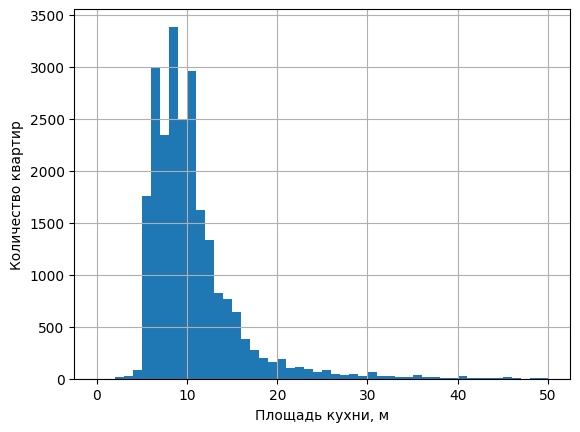

In [85]:
data['kitchen_area'].hist(bins = 50, range = (0,50)) #площадь кухни
plt.xlabel('Площадь кухни, м')
plt.ylabel('Количество квартир')
plt.show()

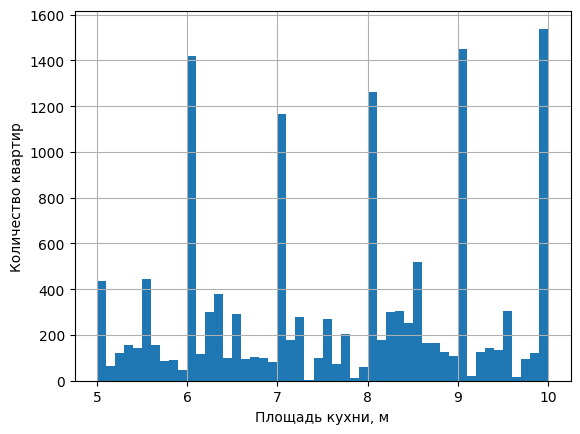

In [86]:
data['kitchen_area'].hist(bins = 50, range = (5,10))
plt.xlabel('Площадь кухни, м')
plt.ylabel('Количество квартир')
plt.show()

Пики наблюдаются в целочисленных значениях (в связи с заполнением этих данных людьми, которые чаще всего знают площадь кухни лишь приблитизительно и округляют).

#### Цена

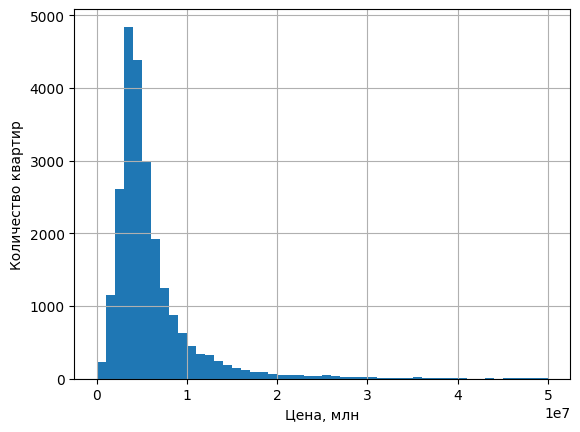

In [87]:
data['last_price'].hist(bins = 50, range = (0,50000000)) #цена
plt.xlabel('Цена, млн')
plt.ylabel('Количество квартир')
plt.show()

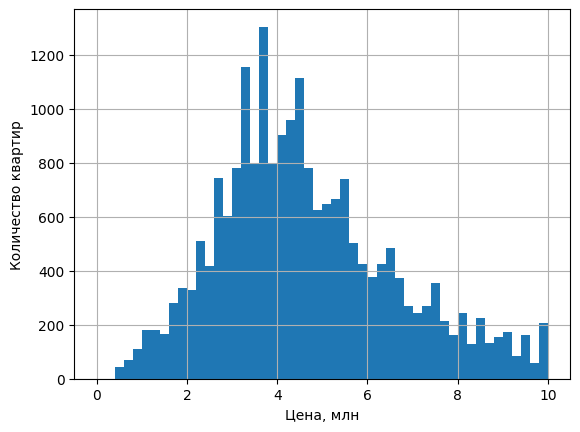

In [88]:
(data['last_price']/1000000).hist(bins = 50, range = (0,10))
plt.xlabel('Цена, млн')
plt.ylabel('Количество квартир')
plt.show()

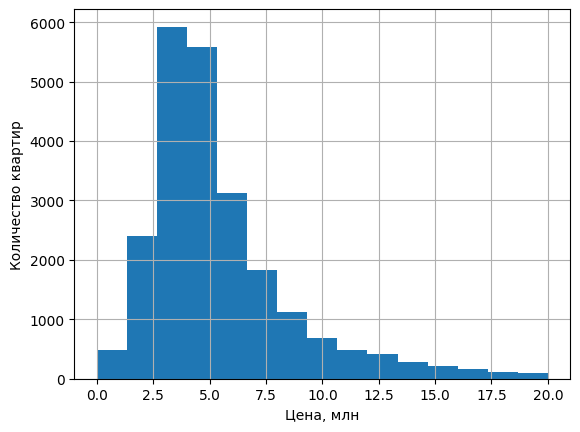

In [89]:
(data['last_price']/1000000).hist(range=(0, 20), bins=15);
plt.xlabel('Цена, млн')
plt.ylabel('Количество квартир')
plt.show()

Наблюдается нормальное распределение, выбросов нет. Длинный хвост говорит нам о том, что на рынке присутствуют квартиры за сколько угодно высокую стоимость.

#### Количество комнат

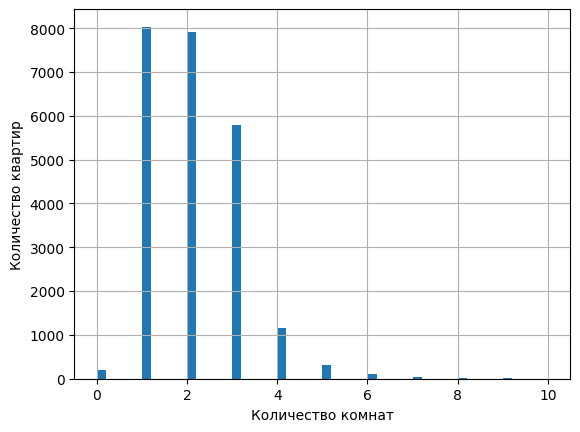

1    8035
2    7922
3    5792
4    1164
5     311
0     196
6      98
7      44
8       9
9       6
Name: rooms, dtype: int64

In [90]:
data['rooms'].hist(bins = 50, range = (0,10)) #количество комнат
plt.xlabel('Количество комнат')
plt.ylabel('Количество квартир')
plt.show()
data['rooms'].value_counts()

По гистограмме видим, что чаще продают однушки и двушки, трешки чуть реже, остальные виды встречаются не часто.

#### Высота потолков

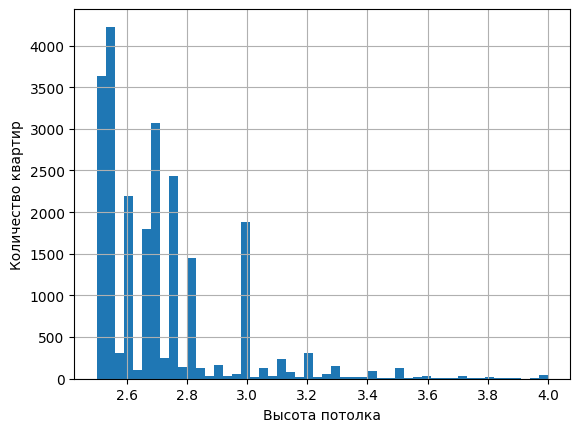

In [91]:
data['ceiling_height'].hist(bins = 50, range = (2.5,4)) #высота потолков
plt.xlabel('Высота потолка')
plt.ylabel('Количество квартир')
plt.show()

График не плавный из-за дискретности значений высоты потолка плюс наличия стандартов строительства, из-за которых видим пики в некоторых значениях.

#### Этаж квартиры

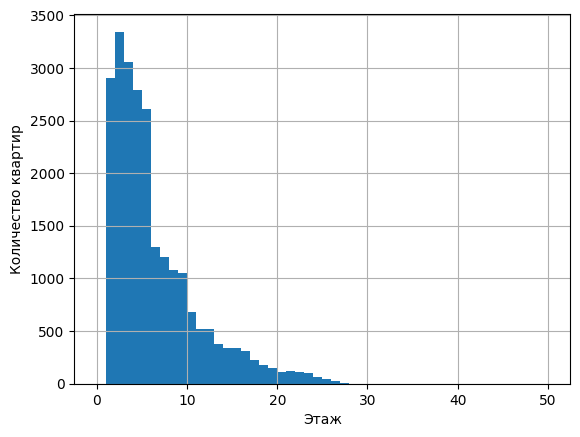

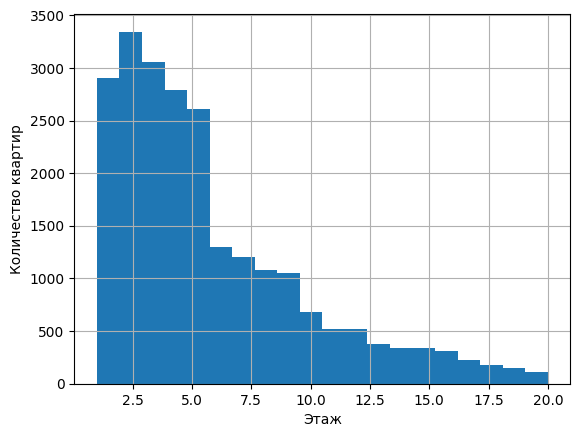

In [92]:
data['floor'].hist(bins = 50, range = (0,50)) #этаж
plt.xlabel('Этаж')
plt.ylabel('Количество квартир')
plt.show()
data['floor'].hist(bins = 20, range = (1,20))
plt.xlabel('Этаж')
plt.ylabel('Количество квартир')
plt.show()

In [93]:
data['floor'].value_counts()

2     3345
3     3053
1     2906
4     2791
5     2610
6     1296
7     1203
8     1080
9     1048
10     686
12     524
11     522
13     379
15     343
14     335
16     315
17     226
18     177
19     147
21     123
22     112
20     110
23      99
24      63
25      44
26      24
27      10
28       1
29       1
32       1
30       1
33       1
31       1
Name: floor, dtype: int64

Пятиэтажки встречаются чаще, чем дома более высокой этажности, в связи с чем и квартир на первых пяти этажах больше, чем квартир на других этажах.

#### Тип этажа дома (первый, последний, не первый и не последний)

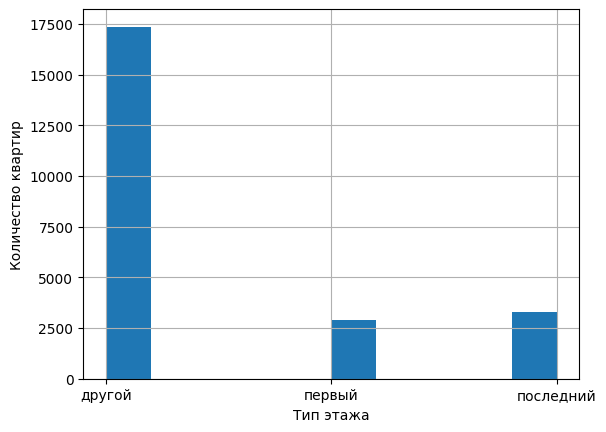

In [94]:
data['floor_type'].hist(bins = 10) #тип этажа
plt.xlabel('Тип этажа')
plt.ylabel('Количество квартир')
plt.show()

Квартиры на первом и на последнем этаже встречаются примерно с одной частотой.

#### Этажность дома

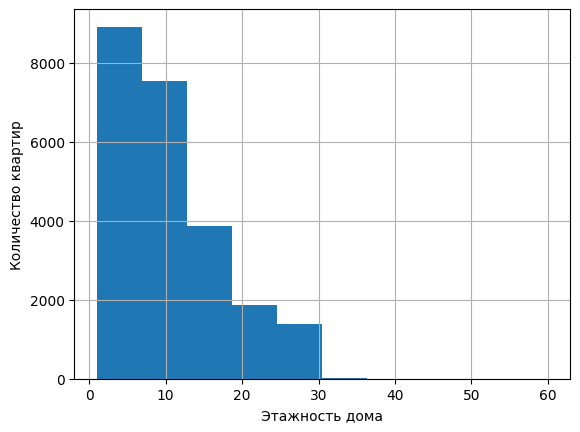

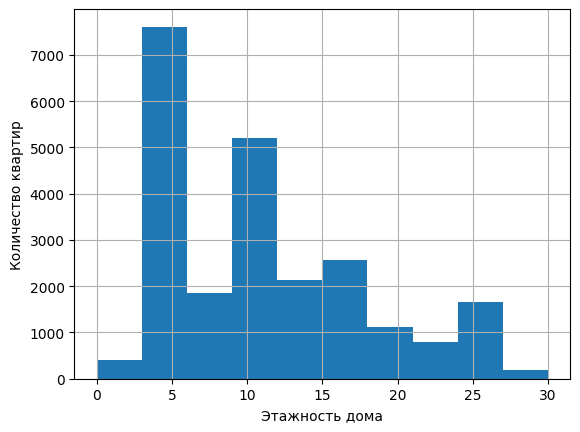

In [95]:
data['floors_total'].hist(bins = 10) #всего этажей
plt.xlabel('Этажность дома')
plt.ylabel('Количество квартир')
plt.show()
plt.show()
data['floors_total'].hist(bins = 10, range =(0,30)) #всего этажей
plt.xlabel('Этажность дома')
plt.ylabel('Количество квартир')
plt.show()

In [96]:
data['floors_total'].value_counts()

5     5766
9     3838
16    1374
12    1360
4     1184
10    1173
25    1073
6      898
17     833
3      660
7      574
14     553
18     505
24     462
8      382
2      379
15     365
23     349
19     339
22     286
20     269
13     228
11     202
27     164
21     158
26     124
1       25
35      24
28      21
36       3
34       1
60       1
52       1
29       1
33       1
37       1
Name: floors_total, dtype: Int64

Подтверждаем вывод из прошлой гистограммы о пятиэтажках. Их на рынке больше всего. На втором месте - девятиэтажки. Дома остальной этажности идут с большим отрывом.

#### Расстояние до центра города

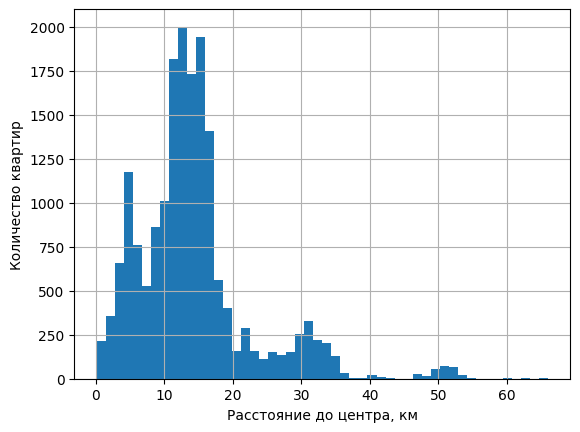

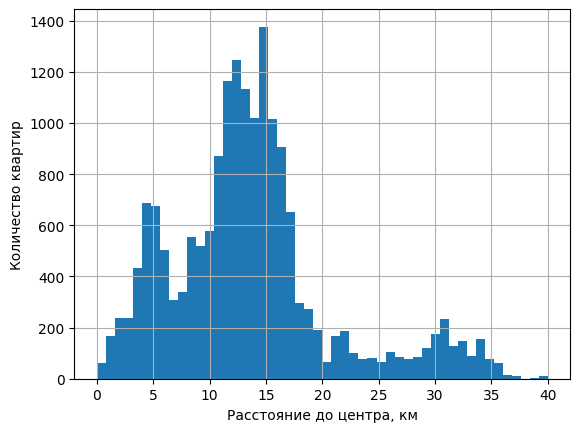

In [97]:
data['cityCenters_nearest_km'].hist(bins=50) #расстояние до центра
plt.xlabel('Расстояние до центра, км')
plt.ylabel('Количество квартир')
plt.show()
data['cityCenters_nearest_km'].hist(bins=50, range = (0,40))
plt.xlabel('Расстояние до центра, км')
plt.ylabel('Количество квартир')
plt.show()

Видим, что основной жилой фонд сосредоточен в радиусе 10-15 км от центра Санкт-Петербурга. Предложений в центре города меньше.

#### Расстояние до аэропорта

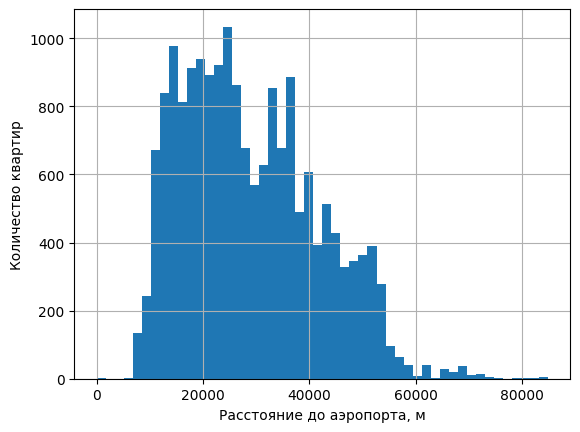

In [98]:
data['airports_nearest'].hist(bins=50) #расстояние до ближайшего аэропорта
plt.xlabel('Расстояние до аэропорта, м')
plt.ylabel('Количество квартир')
plt.show()

In [99]:
data[(data['airports_nearest'] > 25000) & (data['airports_nearest'] < 30000)]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_m2,realty_category,exposition_weekday,exposition_month,exposition_year,cityCenters_nearest_km,floor_type
3,0,64900000.00,159.00,2015-07-24,3,3.30,14,95.00,9,NaN,False,False,15.00,0,Санкт-Петербург,28098.00,6800.00,2,84.00,3,234.00,424,408176.10,Elite,4,7,2015,6.80,другой
27,20,7100000.00,70.00,2017-05-12,3,2.60,17,49.00,11,NaN,False,False,9.20,0,Санкт-Петербург,29197.00,11456.00,2,452.00,1,779.00,151,101428.60,Econom,4,5,2017,11.46,другой
33,8,4800000.00,73.00,2018-10-15,4,2.55,9,51.60,5,NaN,False,False,6.50,0,Колпино,26535.00,32321.00,0,NaN,0,NaN,92,65753.40,Econom,0,10,2018,32.32,другой
63,2,20000000.00,118.00,2018-09-11,3,3.00,9,68.00,7,NaN,False,False,16.00,0,Санкт-Петербург,26055.00,4800.00,1,648.00,1,779.00,37,169491.50,Business,1,9,2018,4.80,другой
74,3,2350000.00,34.00,2018-06-14,1,2.50,9,19.00,8,NaN,False,False,7.10,0,Колпино,26765.00,32551.00,1,445.00,1,996.00,121,69117.60,Econom,3,6,2018,32.55,другой
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23656,13,2600000.00,32.00,2017-07-12,1,2.65,5,18.00,2,NaN,False,False,7.00,0,Колпино,26074.00,31861.00,2,231.00,2,371.00,195,81250.00,Econom,2,7,2017,31.86,другой
23664,5,9000000.00,110.00,2015-12-10,4,3.36,7,64.60,5,NaN,False,False,15.80,0,Санкт-Петербург,26313.00,5016.00,3,417.00,1,118.00,816,81818.20,Econom,3,12,2015,5.02,другой
23675,8,3550000.00,39.50,2016-10-03,1,2.66,16,19.00,13,NaN,False,False,8.50,0,Санкт-Петербург,25740.00,14951.00,0,NaN,0,NaN,721,89873.40,Econom,0,10,2016,14.95,другой
23680,14,5000000.00,59.00,2019-04-04,3,2.50,5,52.00,1,NaN,False,False,7.00,0,Санкт-Петербург,26835.00,11878.00,0,NaN,0,NaN,<NA>,84745.80,Econom,3,4,2019,11.88,первый


Распределение нормальное. Видим по гистограмме, что большая часть квартир находится в радиусе 60 км от аэропорта. А пик приходится на 20 км (расстояние от Санкт-Петербурга до Пулково).

#### Расстояние до ближайшего парка

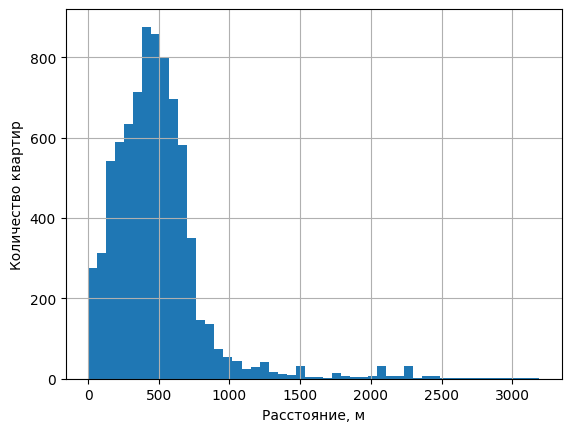

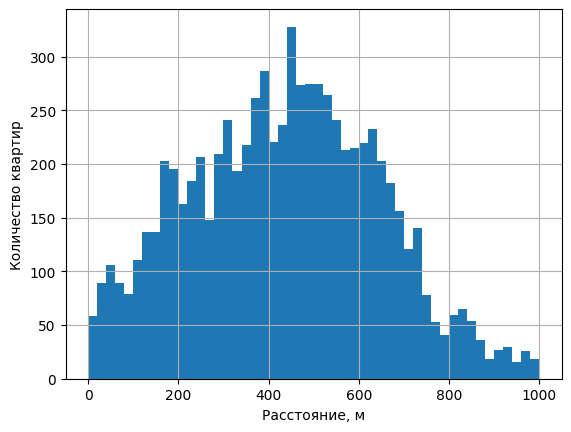

In [100]:
data['parks_nearest'].hist(bins=50) #расстояние до ближайшего парка
plt.xlabel('Расстояние, м')
plt.ylabel('Количество квартир')
plt.show()
data['parks_nearest'].hist(bins=50, range = (0,1000))
plt.xlabel('Расстояние, м')
plt.ylabel('Количество квартир')
plt.show()

Среди тех квартир, в данных которых не было пропусков в столбце расстояния до парка, парки присутствуют в основном в радиусе до 1 км.

#### День недели размещения объявления

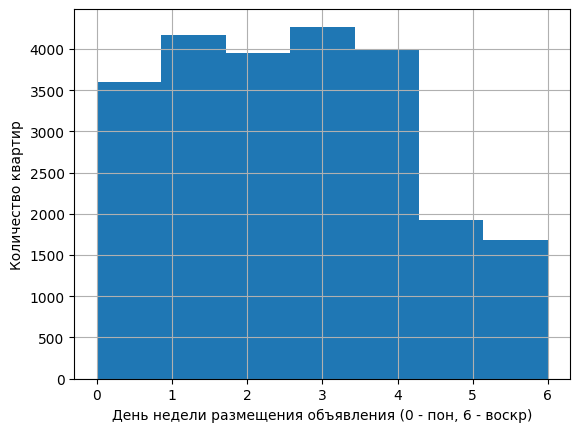

In [101]:
data['exposition_weekday'].hist(bins=7) #день недели, когда объявление было выложено
plt.xlabel('День недели размещения объявления (0 - пон, 6 - воскр)')
plt.ylabel('Количество квартир')
plt.show()

Судя по гистограмме, люди реже занимаются объявлениями о продаже в выходные. Вторник и четверг - самые активные дни.

#### Месяц размещения объявления

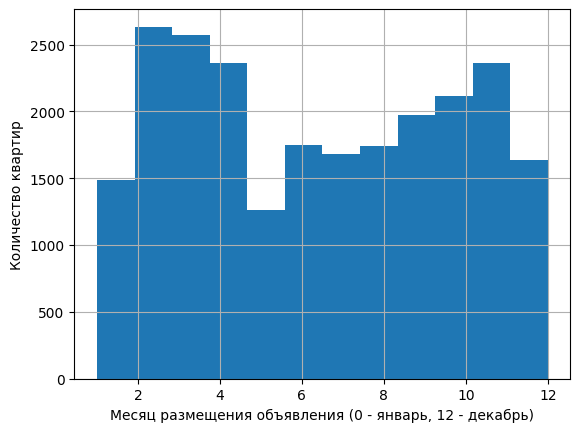

In [102]:
data['exposition_month'].hist(bins=12) #месяц, когда объявление было выложено
plt.xlabel('Месяц размещения объявления (0 - январь, 12 - декабрь)')
plt.ylabel('Количество квартир')
plt.show()

In [103]:
data['exposition_month'].value_counts()

2     2634
3     2571
11    2365
4     2364
10    2115
9     1974
6     1751
8     1738
7     1682
12    1634
1     1484
5     1265
Name: exposition_month, dtype: int64

Февраль, март, апрель и ноябрь - самые активные месяцы на сервисе. В декабре, январе и мае (вероятно, из-за майских праздников) активность падает.

#### Продолжительность продажи квартиры

Изучим, как быстро продавались квартиры.

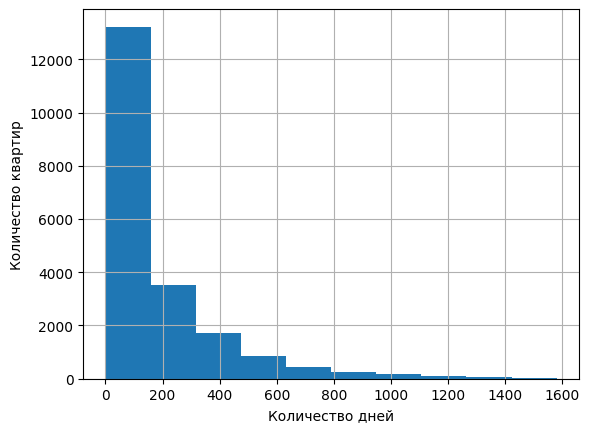

count   20413.00
mean      180.42
std       219.36
min         1.00
25%        45.00
50%        95.00
75%       231.00
max      1580.00
Name: days_exposition, dtype: float64

In [104]:
data['days_exposition'].hist()
plt.xlabel('Количество дней')
plt.ylabel('Количество квартир')
plt.show()
data['days_exposition'].describe()

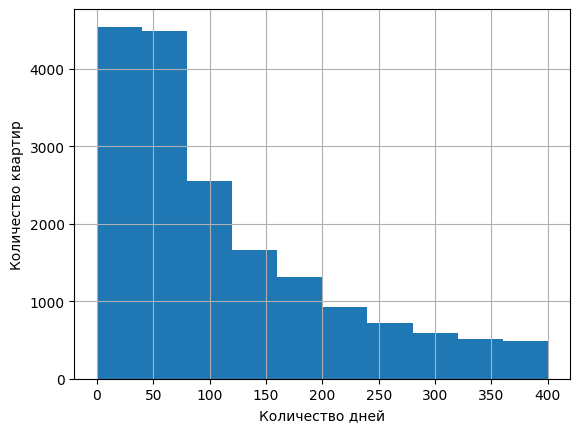

In [105]:
data['days_exposition'].hist(range = (0, 400))
plt.xlabel('Количество дней')
plt.ylabel('Количество квартир')
plt.show()

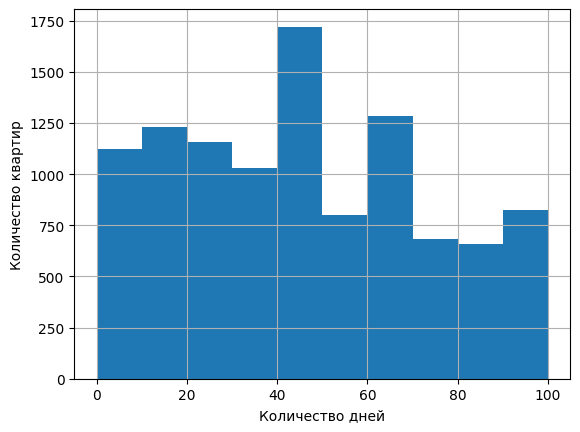

In [106]:
data['days_exposition'].hist(range = (0, 100))
plt.xlabel('Количество дней')
plt.ylabel('Количество квартир')
plt.show()

Половина квартир продается в течение 95 дней. Вероятность продажи квартиры в первые полтора месяца - 25%. Это можно считать быстрыми продажами. Продажи более 8 месяцев - редкие по статистике продажи (менее 25% всех продаж).  
Также наблюдаем пики в районе 45 и 60 дней. Это связано с тем, что по условиям сервиса (https://yandex.ru/support/realty/owner/home/add-ads-housing.html) через 45 и 60 дней (в зависимости от цены) объявления снимаются автоматически.

#### Стоимость недвижимости

Изучим факторы, больше всего влияющие на полную стоимость объекта. 

Построим график корреляции между ценой и площадью .

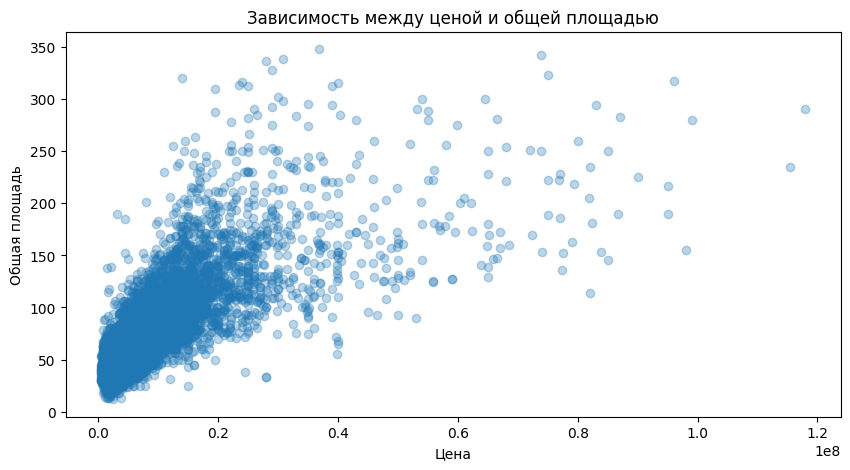

In [107]:
plt.figure(figsize=(10,5))
plt.scatter(data['last_price'], data['total_area'], alpha = 0.3)
plt.xlabel('Цена')
plt.ylabel('Общая площадь')
plt.title('Зависимость между ценой и общей площадью')
plt.show()

На графике видим высокую корреляцию. Очевидно, что существует прямая зависимость между ценой и площадью - чем больше площадь, тем дороже квартира.

Построим такой же график для цены и жилой площади квартиры.

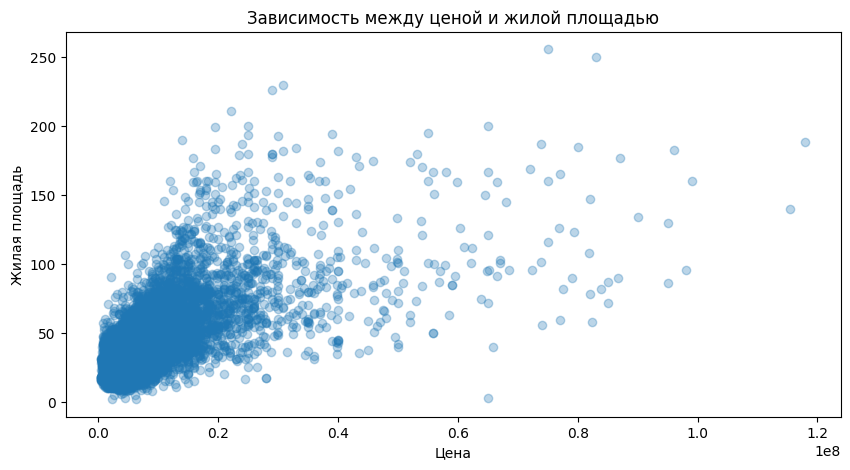

In [108]:
plt.figure(figsize=(10,5))
plt.scatter(data['last_price'], data['living_area'], alpha = 0.3)
plt.xlabel('Цена')
plt.ylabel('Жилая площадь')
plt.title('Зависимость между ценой и жилой площадью')
plt.show()

Корреляция между ценой и жилой площадью чуть ниже, т.к. цену квартиры считают исходя из общей, а не жилой, площади квартиры. Однако зависимость также хорошо прослеживается: чем больше жилая площадь, тем выше цена квартиры.

Построим график зависимости цены от площади кухни.

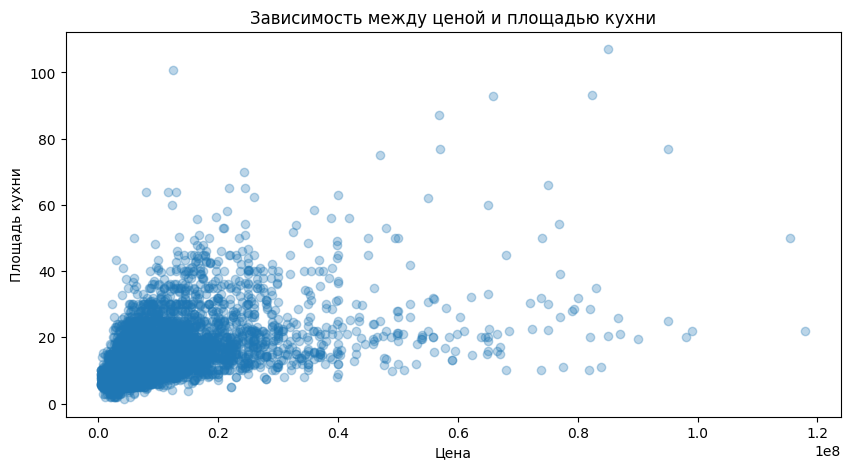

In [109]:
plt.figure(figsize=(10,5))
plt.scatter(data['last_price'], data['kitchen_area'], alpha = 0.3)
plt.xlabel('Цена')
plt.ylabel('Площадь кухни')
plt.title('Зависимость между ценой и площадью кухни')
plt.show()

Зависимость есть, но очевидно, что площадь кухни не так сильно влияет на цену, как общая площадь квартиры. Однако, можно сказать, что большая кухня в целом повышает цену квартиры.

Посмотрим на зависимость цены от количества комнат.

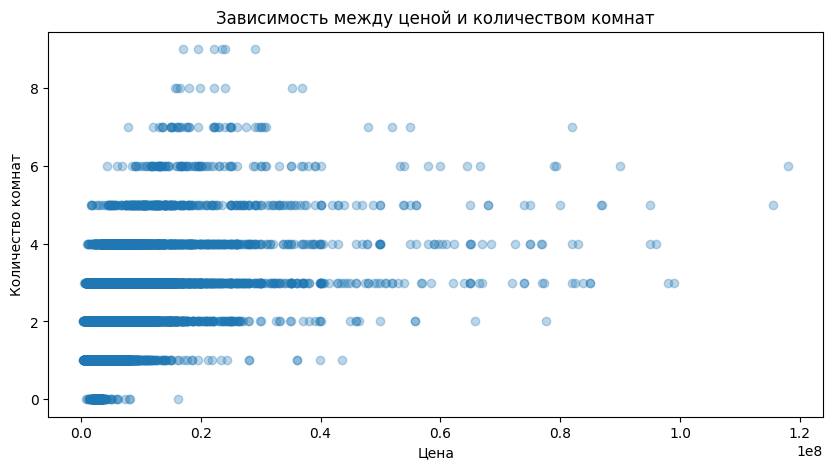

In [110]:
plt.figure(figsize=(10,5))
plt.scatter(data['last_price'], data['rooms'], alpha = 0.3)

plt.xlabel('Цена')
plt.ylabel('Количество комнат')
plt.title('Зависимость между ценой и количеством комнат')
plt.show()

Для наглядности построим сводную таблицу, сгруппировав по количеству комнат.

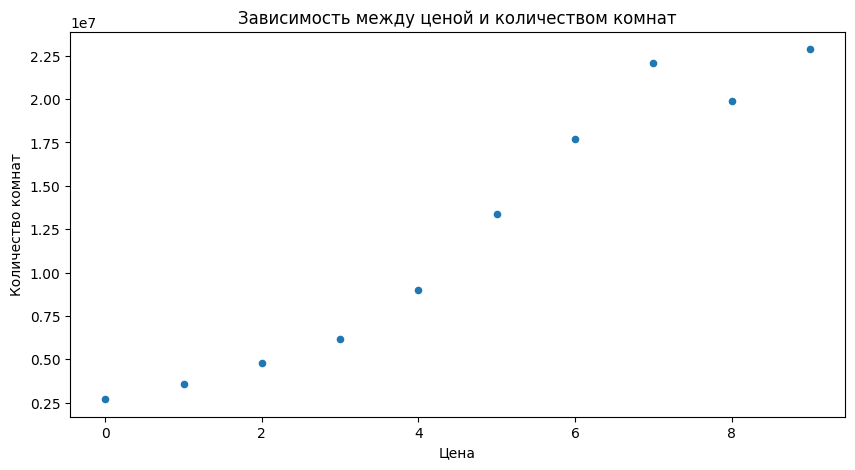

In [111]:
pivot_price_room = data.pivot_table(index='rooms', values='last_price', aggfunc = 'median').reset_index()
pivot_price_room.plot(kind='scatter', y='last_price', x='rooms', alpha=1, figsize=(10,5)) #строим диаграмму рассеивания

plt.xlabel('Цена')
plt.ylabel('Количество комнат')
plt.title('Зависимость между ценой и количеством комнат')
plt.show()

По графику очень хорошо видно нелинейную корреляцию. Для квартир с 8 комнатами и более данных недостаточно, а для квартир до 7 комнат отлично прослеживается связь, подтверждаемая здравым смыслом: чем больше комнат, тем дороже квартира.

Построим такую же сводную таблицу для этажа, на котором расположена квартира.

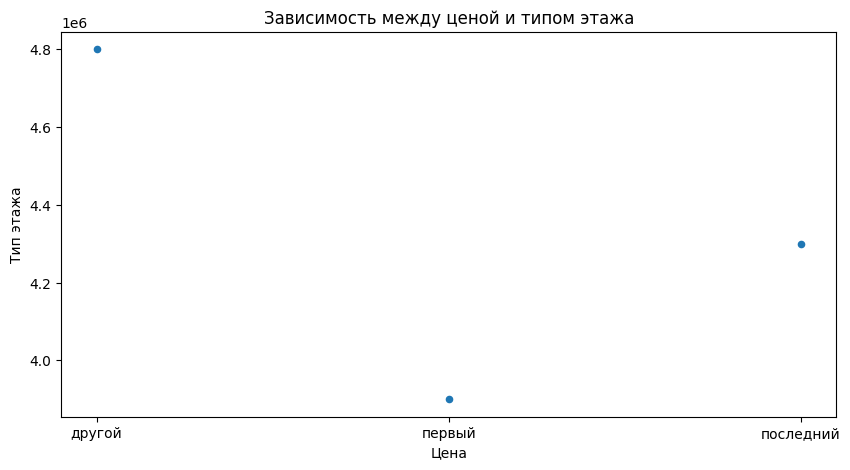

In [112]:
pivot_price_floor_type = data.pivot_table(index='floor_type', values='last_price', aggfunc = 'median').reset_index()
pivot_price_floor_type.plot(kind='scatter', y='last_price', x='floor_type', alpha=1, figsize=(10,5)) #строим диаграмму рассеивания

plt.xlabel('Цена')
plt.ylabel('Тип этажа')
plt.title('Зависимость между ценой и типом этажа')
plt.show()

Хорошо прослеживается связь между ценой и типом квартиры: квартиры на первом этаже продаются дешевле всего, последний этаж ценится больше, но квартиры не на первом и не на последней этаже продаются в среднем дороже.

Проверим, как дата размещения влияет на цену.

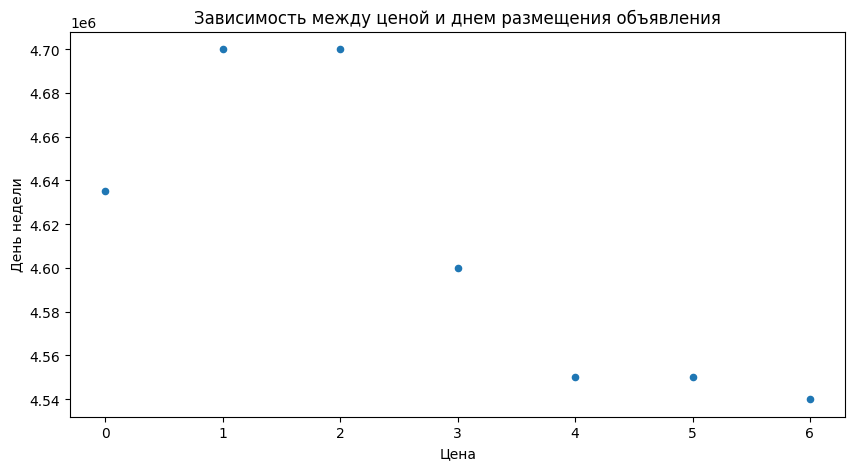

In [113]:
pivot_price_week = data.pivot_table(index='exposition_weekday', values='last_price', aggfunc = 'median').reset_index()
pivot_price_week.plot(kind='scatter', y='last_price', x='exposition_weekday', alpha=1, figsize=(10,5)) #строим диаграмму рассеивания
plt.xlabel('Цена')
plt.ylabel('День недели')
plt.title('Зависимость между ценой и днем размещения объявления')
plt.show()

Судя по графику, присутствует незначительное снижение цены объявлений к концу недели. Пик цены приходится на вторник и среду.

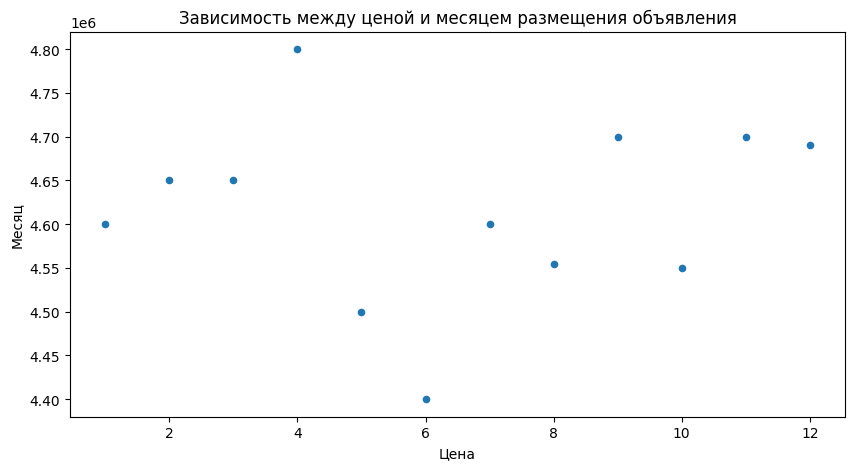

In [114]:
pivot_price_month = data.pivot_table(index='exposition_month', values='last_price', aggfunc = 'median').reset_index()
pivot_price_month.plot(kind='scatter', y='last_price', x='exposition_month', alpha=1, figsize=(10,5)) #строим диаграмму рассеивания

plt.xlabel('Цена')
plt.ylabel('Месяц')
plt.title('Зависимость между ценой и месяцем размещения объявления')
plt.show()

Месяц размещения объявления о продаже квартиры не коррелирует с ценой.

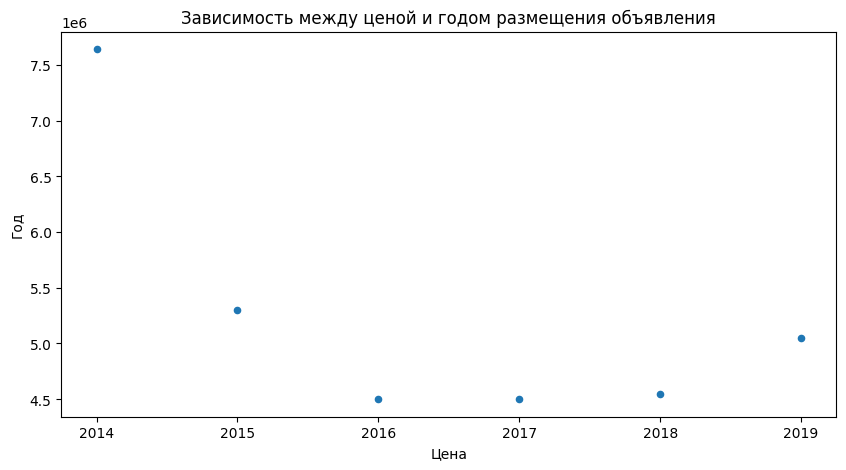

In [115]:
pivot_price_year = data.pivot_table(index='exposition_year', values='last_price', aggfunc = 'median').reset_index()
pivot_price_year.plot(kind='scatter', y='last_price', x='exposition_year', alpha=1, figsize=(10,5)) #строим диаграмму рассеивания

plt.xlabel('Цена')
plt.ylabel('Год')
plt.title('Зависимость между ценой и годом размещения объявления')
plt.show()

В период с 2014 по 2016 год цены на недвижимость падали, далее до 2018 года держались на том же уровне, а в 2019 году начался рост цен.

#### Цена квадратного метра

Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.

In [116]:
pd.set_option('display.max_rows', None)
data['locality_name'].value_counts().head(10) #находим топ 10 городов по количеству объявлений

Санкт-Петербург    15650
Мурино               590
Кудрово              472
Шушары               440
Всеволожск           398
Пушкин               367
Колпино              338
Парголово            327
Гатчина              307
Выборг               237
Name: locality_name, dtype: int64

In [117]:
top10 = data['locality_name'].value_counts().head(10).index.tolist() #создаем список 10 городов с наибольшим числом объявлений
top10

['Санкт-Петербург',
 'Мурино',
 'Кудрово',
 'Шушары',
 'Всеволожск',
 'Пушкин',
 'Колпино',
 'Парголово',
 'Гатчина',
 'Выборг']

In [118]:
data_top10 = data[data['locality_name'].isin(top10)] #создаем новый датайфрейм с данными по 10 выбранным городам
print('Всего осталось строк:', data_top10.shape[0])

Всего осталось строк: 19126


In [119]:
pivot_price_top10 = data_top10.pivot_table(index='locality_name', values='price_m2', aggfunc = 'mean').reset_index()
pivot_price_top10.sort_values(by = 'price_m2', ascending = False)

,locality_name,price_m2
8,Санкт-Петербург,113621.15
7,Пушкин,103130.85
4,Кудрово,95324.93
6,Парголово,90175.92
5,Мурино,86087.51
9,Шушары,78677.36
3,Колпино,75424.58
2,Гатчина,68746.15
0,Всеволожск,68654.48
1,Выборг,58141.91


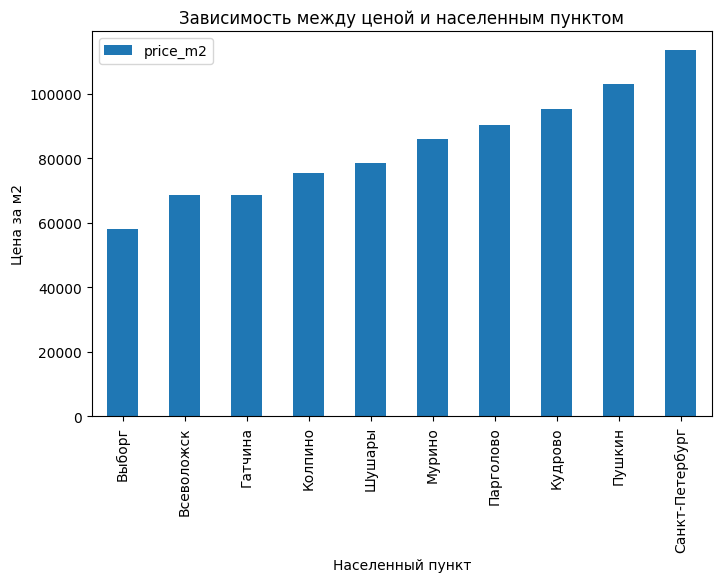

In [120]:
pivot_price_top10.sort_values(by = 'price_m2').plot(kind = 'bar', x = 'locality_name', y ='price_m2', figsize = (8,5))
plt.xlabel('Населенный пункт')
plt.ylabel('Цена за м2')
plt.title('Зависимость между ценой и населенным пунктом')
plt.show()

Населенные пункты с самоый высокой стоимостью недвижимости: Санкт-Петербург, Пушкин и Кудрово. 
<br>
Населенные пункты с самой низкой стоимостью недвижимости: Выборг, Всеволожск и Гатчина.

#### Стоимость каждого километра в Спб

Посчитаем стоимость каждого километра в Санкт-Петербурге.

In [121]:
data_peterburg = data[data['locality_name'] == 'Санкт-Петербург'] #создаем новый датафрейм только для объектов в Санкт-Петербурге
print('Всего осталось строк:', data_peterburg.shape[0])

Всего осталось строк: 15650


In [122]:
data_peterburg = data_peterburg.loc[:, [ 'price_m2', 'cityCenters_nearest_km']]
data_peterburg.head()

,price_m2,cityCenters_nearest_km
0,120370.40,16.03
2,92785.70,13.93
3,408176.10,6.80
4,100000.00,8.10
7,110544.70,11.63


In [123]:
data_peterburg['cityCenters_nearest_km'] = data_peterburg['cityCenters_nearest_km'].dropna() #удаляем строки, где есть пропуски в значении удаленности от центра
data_peterburg['cityCenters_nearest_km'] = (data_peterburg['cityCenters_nearest_km']).round(0) #округляем до целого числа

                        price_m2
cityCenters_nearest_km          
0.00                   231767.96
1.00                   157049.17
2.00                   148437.38
3.00                   121074.49
4.00                   128481.20
5.00                   137643.49
6.00                   146386.52
7.00                   153320.49
8.00                   124988.58
9.00                   113446.20
10.00                  112588.49
11.00                  108678.54
12.00                  107433.29
13.00                  108004.69
14.00                  104643.70
15.00                  104261.67
16.00                  100552.91
17.00                   96481.29
18.00                   96336.42
19.00                   98652.74
20.00                  103045.18
21.00                   94582.03
22.00                   91281.63
23.00                   91828.51
24.00                   85736.90
25.00                   91531.37
26.00                   89285.88
27.00                  132115.70
28.00     

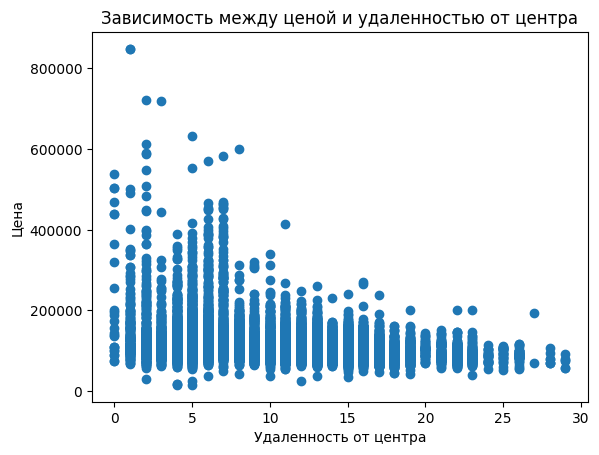

In [124]:
pivot_data_peterburg = data_peterburg.pivot_table(index = 'cityCenters_nearest_km', values = 'price_m2') #строим сводную таблицу
print(pivot_data_peterburg)
plt.scatter(data_peterburg['cityCenters_nearest_km'], data_peterburg['price_m2']) #строим гистограмму
plt.xlabel('Удаленность от центра')
plt.ylabel('Цена')
plt.title('Зависимость между ценой и удаленностью от центра')
plt.show()

Чем недвижимость ближе к центру, тем она дороже.

### Общий вывод

Мы провели исследование рынка недвижимости Санкт-Петербурга и Ленинградской области. В нашем распоряжении были данные сервиса Яндекс Недвижимость — архив объявлений за несколько лет. 
<br>
<br>
На первом этапе мы провели предобработку данных: заполнили пропуски, где это было возможно, удалили дубликаты, изменили типы данных в необходимых для дальнейшего исследования случаях, удалили аномальные значения. Далее мы добавили несколько новых необходимых столбцов и провели исследовательский анализ данных.
<br><br>
**Выводы**:
<br><br>
В основном на рынке представлены квартиры от 20 до 100м2. Самая продаваемая конфигурация квартиры - однушка около 40м2. <br>
Самая распространенная площадь кухни - 10м2.
<br><br>Цены варьируются от 500 тыс до 150 млн рублей и далее. На рынке присутствуют квартиры любой ценовой категории.
<br><br>Чаще продают однушки и двушки, трешки - реже, остальные виды квартир встречаются не часто.
<br><br>Пятиэтажки встречаются чаще, чем дома более высокой этажности. На втором месте по встречаемости - девятиэтажки.
Квартиры на первом и на последнем этаже встречаются примерно с одной частотой. Квартиры на первых этажах традиционно значительно дешевле остальных квартир, также есть тенденция снижения цены для квартир на последних этажах.
<br><br>
Мы проанализировали частоту размещения объявлений в разные дни недели и месяцы. Заметно, что к концу недели объявлений становится значительно меньше, что связано с общей активностью людей по будням и выходным. Вторник и четверг - самые активные дни. Что интересно: цена размещаемых к концу недели квартир слегка ниже. Февраль, март, апрель и ноябрь - самые активные месяцы на сервисе. В декабре, январе и мае (вероятно, из-за майских праздников) активность падает.
<br><br>
Мы изучили, как быстро продавались квартиры. Половина квартир продается в течение 95 дней. Вероятность продажи квартиры в первые полтора месяца - 25%. Это можно считать быстрыми продажами. Продажи более 8 месяцев - редкие по статистике продажи (менее 25% всех продаж).
<br><br>
Перечислим факторы, наиболее сильно влияющие на цену недвижимости. 
**Населенный пункт**: понятно, что в крупном городе недвижимость в целом дороже, чем в области. Также на цену значительно влияет и **расстояние до центра**. **Метраж квартиры** (общая, жилая площади, площадь кухни и количество комнат) - чем больше квартира, там она дороже. Также влияение оказывает и **этаж**, на котором эта квартира расположена. 